### This phase of the development notebook is mostly to figure out the TBC code, and refine the video RF decoding code.

In [1]:
# Just your usual setup

import numpy as np
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 
import matplotlib.pyplot as plt
import sys
import getopt

%matplotlib inline

import matplotlib
matplotlib.rc('figure', figsize=(20, 12))

from datetime import  datetime

import fft8 as fft8 
import ld_utils as utils

import copy

# for image display
from PIL import Image
from IPython.display import HTML
import IPython.display 
from io import BytesIO
from base64 import b64encode

In [2]:
pi = np.pi
tau = np.pi * 2

# Optimal if this is a power of 2
blocklenk = 64
blocklen = (blocklenk * 1024)
# may need to adjust this depending on block length
blockcut = 512

In [3]:
# charting/graphing code carried over from earlier development efforts

def dosplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    db = 20 * np.log10(abs(h))

    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print("-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -10) and (db[i - 1] >= -10):
            print("<-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -20) and (db[i - 1] >= -20):
            print("<-20db crossing at ", w[i] * (freq/pi) / 2.0) 

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    plt.show()

def doplot(B, A, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    db = 20 * np.log10(abs(h))
    for i in range(1, len(w)):
        if (db[i] >= -10) and (db[i - 1] < -10):
            print(">-10db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] >= -3) and (db[i - 1] < -3):
            print(">-3db crossing at ", w[i] * (freq/pi) / 2.0) 
        if (db[i] < -3) and (db[i - 1] >= -3):
            print("<-3db crossing at ", w[i] * (freq/pi) / 2.0) 

    ax1 = fig.add_subplot(111)

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# plot two filters (haven't tested in a long while!)
def doplot2(B, A, B2, A2, freq = (315.0/88.0) * 8.0):
    w, h = sps.freqz(B, A)
    w2, h2 = sps.freqz(B2, A2)

    begin = 0
    end = len(w)
    chop = 0

    w = w[begin:end]
    w2 = w2[begin:end]
    h = h[begin:end]
    h2 = h2[begin:end]

    v = np.empty(len(w))

    hm = np.absolute(h)
    hm2 = np.absolute(h2)

    v0 = hm[0] / hm2[0]
    for i in range(0, len(w)):
        v[i] = (hm[i] / hm2[i]) / v0

    fig = plt.figure()
    plt.title('Digital filter frequency response')

    ax1 = fig.add_subplot(111)

    v  = 20 * np.log10(v )

    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h)), 'r')
    plt.plot(w * (freq/pi) / 2.0, 20 * np.log10(abs(h2)), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    angles2 = np.unwrap(np.angle(h2))
    plt.plot(w * (freq/pi) / 2.0, angles, 'g')
    plt.plot(w * (freq/pi) / 2.0, angles2, 'y')
    plt.ylabel('Angle (radians)', color='g')

    plt.grid()
    plt.axis('tight')
    plt.show()

# This matches FDLS-based conversion surprisingly well (i.e. FDLS is more accurate than I thought ;) )
def BA_to_FFT(B, A, blocklen):
    return np.complex64(sps.freqz(B, A, blocklen, whole=True)[1])

# Draws a uint16 image as a uint8, defaults to one frame
def drawdata(bm, x = 2800, y = 525, hscale = 1, vscale = 2, outsize = None):
#    bmf = np.float32(bm) / 65536.0
    if y is None:
        y = len(bm) // x
        
    if outsize is None:
        outsize = (x * hscale, y * vscale)
    
    bmf = np.uint8(bm[0:x*y] / 256.0)
    print(bmf.shape)
    if x is not None:
        bms = (bmf.reshape(len(bmf)//x, -1))
    else:
        bms = bmf
    
    print(bms.dtype, bms.shape, bms[:][0:y].shape)
    im = Image.fromarray(bms[0:y])
    im = im.resize(outsize)
    b = BytesIO()
    im.save(b, format='png')
    return IPython.display.Image(b.getvalue())


In [24]:
# System default specs for NTSC and PAL.

NTSC_hz_ire = (9300000 - 7600000) / 140.0 # Later disks may have a higher white point

SysParams_NTSC = {
    'system_name': 'NTSC',
    
    'audio_lfreq': 2301136,
    'audio_rfreq': 2812499,

    'analog_audio': True,

    'fsc_mhz': (315.0 / 88.0),
    'line_period': 63.5, # in usecs

    # video frequencies 
    # per spec, range from -40 to 100 IRE is 1.7mhz, so 12142 ire/mhz
    'hz_ire': NTSC_hz_ire,
    
    'videorf_sync'  : 8100000-(NTSC_hz_ire * -40),
    'videorf_0ire'  : 8100000,
    'videorf_7.5ire': 8100000+(NTSC_hz_ire*7.5),
    'videorf_100ire': 8100000+(NTSC_hz_ire*100), # NOTE: slightly higher on later disks

    # IRE range is actually -40 to 110, but leave some margin here and match 0-65534 scaling
    'ire_min': -60,
    'ire_max': 140,

    # tunable parameters.  These work well with DD 2_2 + eliptical filter, which is a bit more
    # picky about audio RF filtering.
    
    #'deemp': (120, 320), # actual deemp timing... at least the usec #'s.
    'deemp': (120*.7, 320*.7), # On some captures this is as low as .55.

    # The audio notch filters didn't work right until the ellipcital filter was implemented...
    'audio_filtwidth': 150000,
    'audio_filtorder': 2,

    # similar but not identical to what Pioneer did
    'vbpf': (3500000, 13200000),
    'vbpf_order': 3,
    
    # This can easily be pushed up to 4.5mhz...
    'vlpf_freq': 4200000,   # in mhz
    'vlpf_order': 5 # butterworth filter order
    
}

SysParams_PAL = {
    # System parameters
    'system_name': 'PAL',

    'fsc_mhz': 4.43361875,
    'line_period': 64, # in usecs
    
    'audio_lfreq': 683593,
    'audio_rfreq': 1066400,

    # video frequencies 
    'videorf_sync': 6760000, # on LD this includes a very strong pilot signal
    'videorf_0ire': 7100000,
    'videorf_100ire': 7900000,

    'ire_min': -95, # needed for pilot signal
    'ire_max': 145,

    # changeable defaults
    'analog_audio': False, # not true for later PAL

    'deemp': (100, 400),

    # XXX: guessing here!
    'vbpf': (2600000, 11000000),
    'vbpf_order': 3,
    'vlpf_freq': 4800000,	# in mhz
    'vlpf_order': 5,		# butterworth filter order

    'audio_filtwidth': 200000,
    'audio_filtorder': 1,
}

# support reloading/rerunning from ipython
try:
    # a dummy load
    tmp = SysParams['fsc_mhz']
except:
    SysParams = copy.deepcopy(SysParams_NTSC)
    

In [5]:
# Domesday Duplicator system uses 32mhz/10bit, expressed as 16-bit signed integers
CapParams_DomesdayDuplicator = {
    'freq': 40.0,
    'dtype': np.int16,
}

# cxadc can only really capture at 8fsc (28.8xmhz), with 8-bit unsigned samples
# (I haven't used cxadc data in this dev cycle, so the parameters are probably wrong!)
CapParams_cxadc = {
    'freq': (315.0 / 88.0) * 8.00,
    'dtype': np.uint8,
}

In [6]:
CapParams = CapParams_DomesdayDuplicator
SysParams = copy.deepcopy(SysParams_NTSC)

In [7]:
OverrideParams = {}

params = {}

for p in [SysParams, CapParams, OverrideParams]:
    for k in p.keys():
        print(k, p[k])
        params[k] = p[k]

system_name NTSC
audio_lfreq 2301136
audio_rfreq 2812499
analog_audio True
fsc_mhz 3.5795454545454546
line_period 63.5
hz_ire 12142.857142857143
videorf_sync 8585714.285714285
videorf_0ire 8100000
videorf_7.5ire 8191071.428571428
videorf_100ire 9314285.714285715
ire_min -60
ire_max 140
deemp (84.0, 224.0)
audio_filtwidth 150000
audio_filtorder 1
vbpf (3500000, 13200000)
vbpf_order 3
vlpf_freq 4200000
vlpf_order 5
freq 40.0
dtype <class 'numpy.int16'>


In [8]:
def inrange(a, mi, ma):
    return (a >= mi) & (a <= ma)

def sqsum(cmplx):
    return np.sqrt((cmplx.real ** 2) + (cmplx.imag ** 2))

In [9]:
# from http://tlfabian.blogspot.com/2013/01/implementing-hilbert-90-degree-shift.html
hilbert_filter = np.fft.fftshift(
    np.fft.ifft([0]+[1]*200+[0]*200)
)

# Now construct the FFT transform of the hilbert filter.  
# This can be complex multiplied with the raw RF to do the 'heavy lifting'
fft_hilbert = np.fft.fft(hilbert_filter, blocklen)

def filtfft(filt, blen = blocklen):
    return sps.freqz(filt[0], filt[1], blen, whole=1)[1]

Decoding notes:

- My RF decoder is based off frequency-domain transforms.  This allows multiple filters to be applied in one operation, and multiple different filters can also be applied, which will come into play when working on audio

In [10]:
# A rather pants attempt at doing an MTF function, but it seems to work well...
[tf_b, tf_a] = sps.zpk2tf(.1, -.5, 1.0)
Fmtf = filtfft([tf_b, tf_a])

# This prepares the needed transforms to do the actual video decoding
def prepare_video_filters(params):
    SP = copy.deepcopy(params)
    
    SP['freq_hz'] = SP['freq'] * 1000000.0
    SP['line_px'] = SP['freq_hz'] * (SP['line_period'] / 1000000.0)
        
    freq_hz = SP['freq_hz']
    freq_hz_half = SP['freq_hz'] / 2
    freq_half = SP['freq'] / 2

    # RF BPF and analog audio cut filters
    SP['FRFVideo'] = filtfft(sps.butter(SP['vbpf_order'], [SP['vbpf'][0]/freq_hz_half, SP['vbpf'][1]/freq_hz_half], btype='bandpass'))
    
    # If there is analog audio, it must be filtered well especially with DD >=2.2 RF captures
    if SP['analog_audio'] and SP['audio_filtorder']: 
        SP['Fcutl'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_lfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_lfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        SP['Fcutr'] = filtfft(sps.butter(SP['audio_filtorder'], [(SP['audio_rfreq'] - SP['audio_filtwidth'])/freq_hz_half, (SP['audio_rfreq'] + SP['audio_filtwidth'])/(freq_hz_half)], btype='bandstop'))
        
        SP['FRFVideo'] *= (SP['Fcutl'] * SP['Fcutr'])
    
    # standard post-demod LPF
    SP['Fvideo_lpf'] = filtfft(sps.butter(SP['vlpf_order'], SP['vlpf_freq']/freq_hz_half, 'low')) # standard 4.Xmhz

    # post-demodulation deemphasis filter
    [tf_b, tf_a] = sps.zpk2tf(-SP['deemp'][1]*(10**-10)/2.0, -SP['deemp'][0]*(10**-10)/2.0, SP['deemp'][0] / SP['deemp'][1])
    SP['Fdeemp'] = filtfft(sps.bilinear(tf_b, tf_a, 1.0/freq_hz_half))

    # Post processing:  lowpass filter + deemp
    SP['FVideo'] = SP['Fvideo_lpf'] * SP['Fdeemp'] 
    
    # additional filters:  0.5mhz and color burst
    SP['F0_5'] = filtfft(sps.butter(1, 0.5/freq_half, 'low')) 
    SP['FVideo05'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['F0_5']

    if SP['system_name'] == 'NTSC':
        SP['Fcburst'] = filtfft(sps.butter(1, [(SP['fsc_mhz'] * .95)/freq_half, (SP['fsc_mhz'] * 1.05)/freq_half], btype='bandpass')) 
    else:
        SP['Fcburst'] = filtfft(sps.butter(1, [3.7/freq_half, 3.8/freq_half], btype='bandpass')) 
        
    SP['FVideoBurst'] = SP['Fvideo_lpf'] * SP['Fdeemp']  * SP['Fcburst']
    
    # emperical work determined that a single-pole low frequency filter effectively 
    # detects the end of a (regular) sync pulse when binary level detection is used. TODO: test with PAL
    f = sps.butter(1, 0.05/(params['freq'] / 2.0), btype='low')
    SP['FPsync'] = filtfft(f)
    
    return SP

In [92]:
# The actual video demodulation code

def dodemod(paramsc, data, clip = None, usemtf = False, cutarf = False):
    indata_fft = np.fft.fft(data)
    indata_fft_filt = indata_fft * paramsc['FRFVideo']

    if usemtf:
        indata_fft_filt *= Fmtf

    hilbert = np.fft.ifft(indata_fft_filt * fft_hilbert)

    tangles = np.angle(hilbert)
    dangles = np.pad(np.diff(tangles), (1, 0), mode='constant')

    # make sure unwapping goes the right way
    if (dangles[0] < -pi):
        dangles[0] += tau

    tdangles2 = np.unwrap(dangles) 
    # With extremely bad data, the unwrapped angles can jump.
    while np.min(tdangles2) < 0:
        tdangles2[tdangles2 < 0] += tau
    while np.max(tdangles2) > tau:
        tdangles2[tdangles2 > tau] -= tau
    demod = (tdangles2 * (paramsc['freq_hz'] / tau))

    demod_fft = np.fft.fft(demod)
    
    out_video = np.fft.ifft(demod_fft * paramsc['FVideo']).real
    out_video05 = np.fft.ifft(demod_fft * paramsc['FVideo05']).real
    out_videoburst = np.fft.ifft(demod_fft * paramsc['FVideoBurst']).real
    
    return np.rec.array([out_video, out_video05, out_videoburst], names=['demod', 'demod_05', 'demod_burst'])
    #return out_video, out_video05, out_videoburst

In [93]:
def lineplot(output, param):
    plt.plot(output)
    
    if param['system_name'] == 'PAL':
        plt.axhline(7100000, color='black') # black
        plt.axhline(7900000, color='black') # white

        # burst
        plt.axhline(7100000 - (800000 * 1.5 / 7), color='g')
        plt.axhline(7100000 + (800000 * 1.5 / 7), color='g')

        # pilot low (pilot high is 7.1mhz)
        plt.axhline((7900000-(800000/.7))-(800000*(3/7)), color='b')
    else: # NTSC
        
        plt.axhline(params['videorf_0ire'], color='black') # 0IRE
        plt.axhline(params['videorf_7.5ire'], color='black') # black for most disks
        plt.axhline(params['videorf_100ire'], color='black') # white

        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 80), color='blue')
        
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * 20), color='green')
        plt.axhline(params['videorf_0ire'] - (params['hz_ire'] * 20), color='green')
        
        # sync
        plt.axhline(params['videorf_0ire'] + (params['hz_ire'] * -40), color='blue')

In [94]:
def calcsnr(a):
    stdire = np.std(a) / NTSC_hz_ire
    return(20 * np.log10(100 / stdire))

In [95]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [126]:
def demod(infile, _start, _end, filterset):
    infile_len = infile.seek(0, 2)
    
    if _end > infile_len:
        end = infile_len
    else:
        end = _end
    
    if (_start > blockcut):
        start = _start - blockcut
    else:
        start = 0 # should this be an error?  prolly.

    print(start, end, (end - start))
    
    # set a placeholder
    output = None #np.zeros(end - start + 1, dtype=('double, double, double'))
        
    for i in range(0, end - start, blocklen - blockcut):
        infile.seek(i, 0)
        inbuf = infile.read(blocklen * sampletype)
        if sampletype == 2:
            indata = np.fromstring(inbuf, 'int16', len(inbuf) // 2)
        else:
            indata = np.fromstring(inbuf, 'uint8', len(inbuf))
    
        if len(indata) < blocklen:
            print('b', len(indata), blocklen)
            break
    
        tmp = dodemod(filterset, indata, usemtf=True)
        
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=tmp.dtype)
        #return dodemod(filterset, indata, usemtf=True)
        
        output_slice = slice(i, i + (blocklen - blockcut))
        if i + (blocklen - blockcut) < len(output):
            tmp_slice = slice(blockcut, len(output))
        else:
            tmp_slice = slice(blockcut, blockcut+len(output)-i)

        output[output_slice] = tmp[tmp_slice]

    return output

In [129]:
if False: # DD 2.2/330pF and later
    params['freq'] = 40.0
    deemp_adj = .65
    params['deemp'] = (120*deemp_adj, 320*deemp_adj)
    sampletype = 2
else: # cxadc capture
    params['freq'] = 8 * 315 / 88
    sampletype = 1

    deemp_adj = 1
    params['deemp'] = (140*deemp_adj, 320*deemp_adj)
    
    params['vbpf'] = (3500000, 13500000)
    params['vbpf_order'] = 3

    params['vlpf_freq'] = 4200000
    params['vlpf_order'] = 3

filterset = prepare_video_filters(params)

infile = open('/home/cpage/ldcaps/ggv1069-22000.raw', 'rb')
tmp= demod(infile, 50000, 2000000, filterset)

49488 2000000 1950512


In [120]:
tmp

array([( 8430190.63967422,  8749636.55002742, -370532.99419882),
       ( 8687593.29580776,  8729779.92672774, -111200.95170483),
       ( 9009090.15611092,  8742122.27982031,  212968.9341262 ), ...,
       ( 8208245.36096322,  8131826.79237298,  106611.96764216),
       ( 8072904.31618609,  8132737.46913219,  -25979.75870234),
       ( 7951611.78421523,  8120195.49070003, -143632.27995079)],
      dtype=(numpy.record, [('demod', '<f8'), ('demod_05', '<f8'), ('demod_burst', '<f8')]))

In [117]:
tmp['f0']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [68]:
tmpr = np.rec.array(tmp, names=['demod', 'demod_05', 'demod_burst'])

In [72]:
tmpr.demod_05

array([ 9032856.09350083,  8980488.05079213,  8861404.35913405, ...,
        9040363.66412466,  9039883.90775138,  9041151.2242277 ])

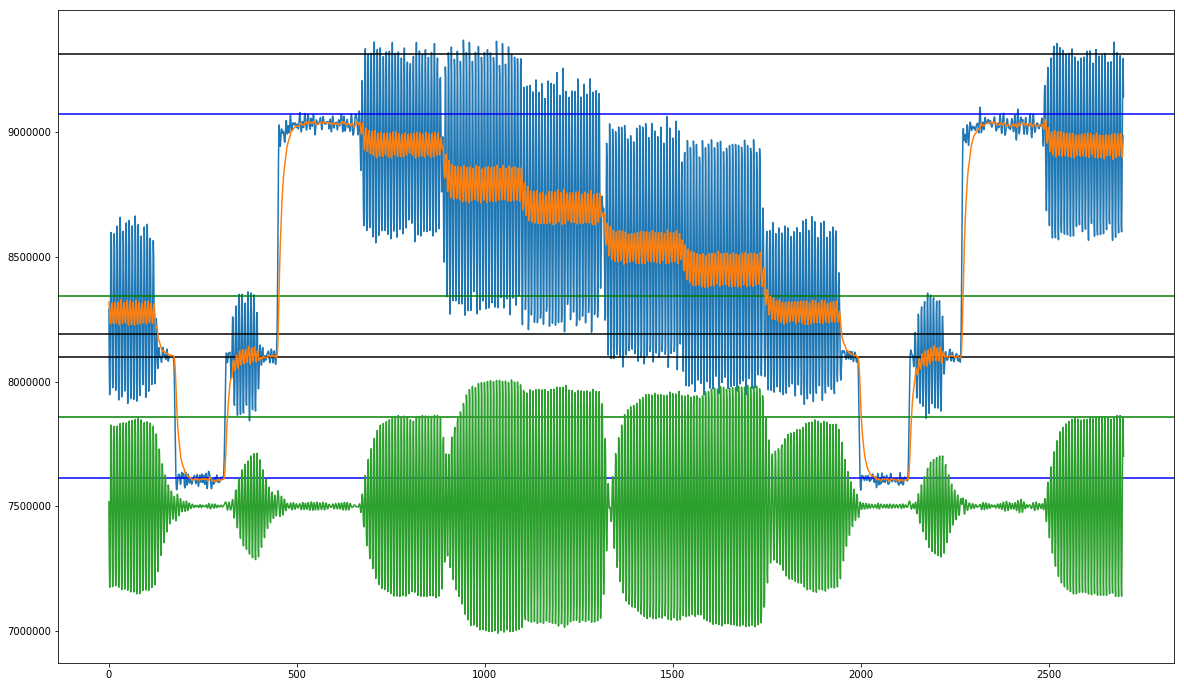

In [70]:
lineplot(tmpr.demod[1300:4000], filterset)
plt.plot(tmpr.demod_05[1300:4000])
plt.plot(tmpr.demod_burst[1300:4000] + 7500000)

In [71]:
calcsnr(tmpr.demod[1800:1920])

36.257963918653751

Below this is the less developed code to deal with NTSC framing and syncs.

In [193]:
output[50000:50005], output[-50005:-50000]

(array([ 8510112.47687857,  8585086.05996054,  8484945.93285329,
         8272120.57964694,  8076035.29492171]),
 array([ 8879976.73210521,  8830123.81220354,  8605568.01861179,
         8341667.92339254,  8189470.13149166]))

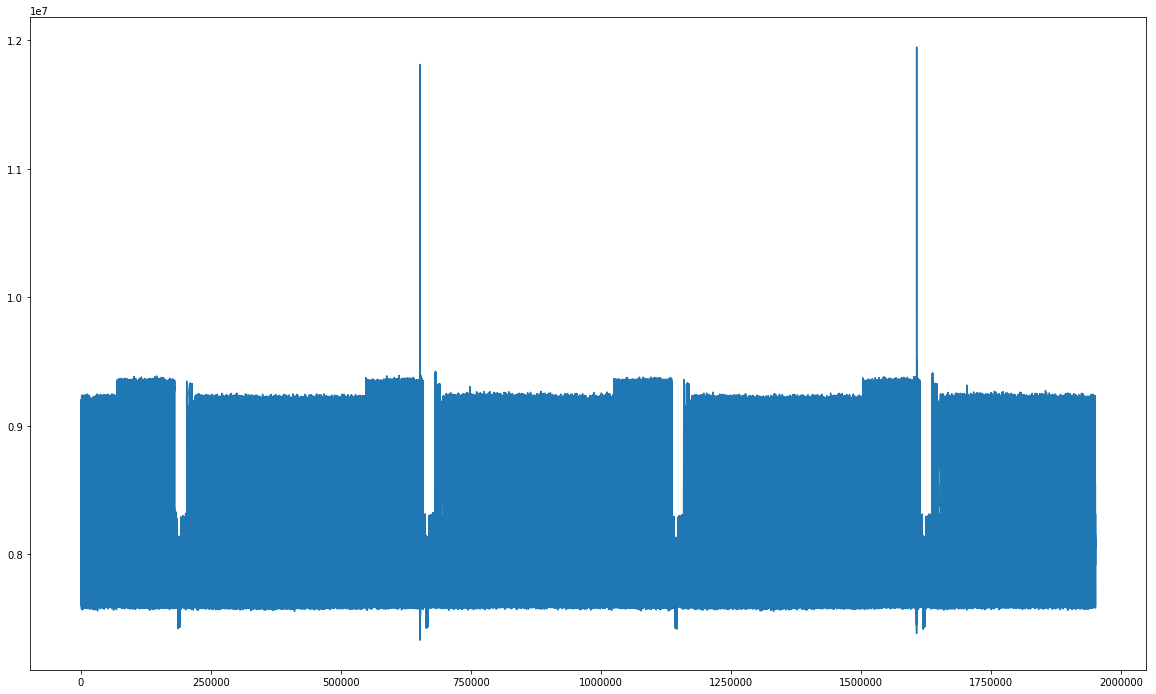

In [194]:
plt.plot(output)

A plot of output_syncf here shows a nice pattern overall:

- Vsyncs reach 1.0 (and the mininum in those areas is ~0.23)
- regular hsyncs come in about 0.77 (the glitches are where the LD player "rewinds" for still frames)
- equalization pulses come in about 0.5

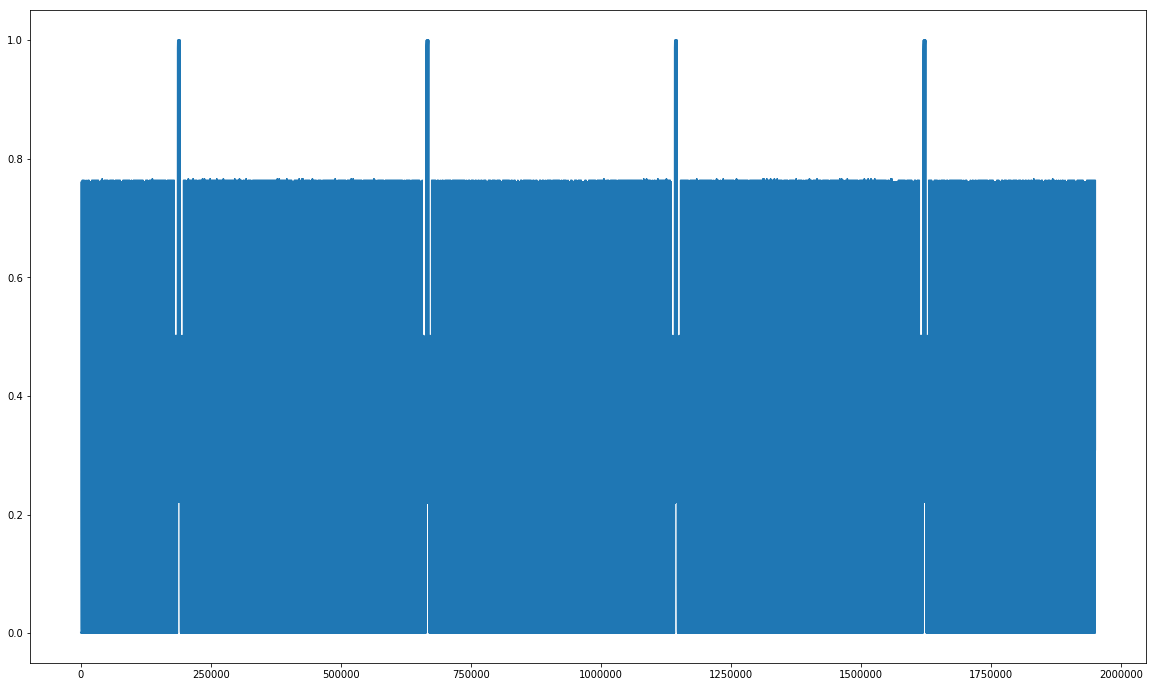

In [147]:
# This shows some nice patterns.  The glitches near the odd #'d syncs
plt.plot(output_sync)

In [148]:
# state 1: find vsync and first full hsync.  determine which line it is as well...

loc = 1000000
imglen = (int)((filterset['freq_hz'] / 59.976) * 1.25)

if (loc + imglen) > len(output_sync):
    print("get more data")

# find the next sync point.  should be > .9
syncloc = np.argmax(output_sync[loc:loc+imglen]) + loc

if np.max(output_sync[loc:loc+imglen]) < .9:
    print("oops.  can't find a good sync")

syncloc

1143851

In [149]:
def findburstfromsync(syncf, center):
    ilinepx = int(filterset['line_px'])

    if syncf[center] < .2:
        print('invalid location')
    try:
        scanarea = (ilinepx * 6)
        threshold = .15

        startsync = center - scanarea + np.where(syncf[center - scanarea:center] < threshold)[0][-1]
        # note: endsync usually includes the first equalization pulse
        endsync = center + np.where(syncf[center:center + scanarea] < threshold)[0][0]
    except:
        print('oh oh, sync ends not found')

    try:
        lastlinepresync = (startsync - (ilinepx * 4)) + np.where(syncf[startsync - (ilinepx * 4): startsync] > .55)[0][-1]
        # compute equalization length with .08 compensation factor
        presync_eqlen = ((startsync - lastlinepresync) / ilinepx) + .08
    except:
        print("error: couldn't find prev line")
        lastlinepresync = None
        presync_eqlen = None

    try:
        nextline = endsync + np.where(syncf[endsync: endsync + (ilinepx * 4)] > .55)[0][0]
        # the offset is larger here since the first equalization pulse is close enough to the end of vsync
        postsync_eqlen = ((nextline - endsync) / ilinepx) + .56
    except:
        print("error: couldn't find next line")
        nextline = None
        postsync_eqlen = None

    return (lastlinepresync, nextline, presync_eqlen, postsync_eqlen)

prevline, nextline, pregap, postgap = findburstfromsync(output_sync, syncloc)

In [150]:
reduced = (output - minn) / hz_ire_scale
output_u16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

In [151]:
# state 2: find the (rough) locations of each following line

ilinepx = int(filterset['line_px'])
lines = np.zeros((255 * ilinepx), dtype=np.uint16)

curloc = nextline

lineinfo = [curloc]
for i in range(0, 253):
    prevloc = curloc
    
    curloc += int(filterset['line_px'] * .9)
    offset = np.argmax(output_sync[curloc:curloc + int(filterset['line_px'] * .2)])
    curloc += offset 
    
    # if the sync detection burst doesn't look good, reuse the last one
    is_validlinegap = inrange((curloc - prevloc), filterset['line_px'] * .997, filterset['line_px'] * 1.003)
    validaftersync = (np.max(output[curloc:curloc + 20]) < 8500000) and (np.min(output[curloc:curloc + 20]) >= 7600000)
    if (i >= 3) and (((output_sync[curloc] < .7) and not is_validlinegap) or not validaftersync):
        print(i, curloc)
        curloc = prevloc + (lineinfo[-1] - lineinfo[-2])
        
    print(curloc, output[curloc], output[curloc+8])

    lineinfo.append(curloc)
    
    lines[i * ilinepx:(i * ilinepx)+(curloc - prevloc)] = output_u16[prevloc:curloc]
    
#    if (i == 119):
#        break

1155043 7735076.30585 8045342.70837
1156863 7728268.96407 8049064.6099
1158684 7765897.29724 8078202.9789
1160504 7709751.39418 8063876.54849
1162325 7772570.60474 8082889.60859
1164145 7764411.2514 8046812.01303
1165966 7782457.86302 8050245.65714
1167786 7754294.8769 8071340.6346
1169606 7727091.52693 8076936.17154
1171427 7743374.05886 8057094.84925
1173247 7749162.45982 8046680.01785
1175068 7775060.10643 8036796.26924
1176888 7736777.60873 8051128.54123
1178708 7701394.89602 8063085.42145
1180529 7771489.98676 8028304.46312
1182349 7714187.04641 8058734.10287
1184170 7791964.10509 8058988.83536
1185990 7749265.71597 8065383.79098
1187810 7720083.08037 8081399.72129
1189631 7749897.21942 8050607.0721
1191451 7743305.9645 8051965.57978
1193272 7765321.79108 8064246.05081
1195092 7749034.0661 8058183.27911
1196912 7726830.86341 8066797.75338
1198733 7782751.37907 8071570.95182
1200553 7724366.66497 8064109.71151
1202374 7782853.3774 8049738.07877
1204194 7777279.92462 8053927.28988
1

In [152]:
def iretohz(ire):
    return 8100000+(hz_ire_scale*ire)

In [153]:
m20ire = 8100000-hz_ire_scale*20

In [154]:
# crude zero-crossing calculator.

def calczc(data, start_offset, target, count=10):
    if data[start_offset] < target:
        locs = np.where(data[start_offset:start_offset+count] >= target)[0]
        offset = 0
    else:
        locs = np.where(data[start_offset:start_offset+count] <= target)[0]
        offset = -1
    
    if len(locs) == 0:
        return None
        
    x = start_offset + locs[0]
    
    a = data[x - 1] - target
    b = data[x] - target
    
    y = -a / (-a + b)

    #print(x, y, locs, data[start_offset:start_offset+locs[0] + 1])

    return x-1+y


In [155]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


1155043 7735076.30585 7823921.51704 7920023.43538
1156863 7728268.96407 7817495.76114 7905149.26079
1158684 7765897.29724 7857918.55238 7940231.13027
1160504 7709751.39418 7798886.97344 7903890.84203
1162325 7772570.60474 7851177.6234 7924421.87145
1164145 7764411.2514 7845675.19337 7919493.34528
1165966 7782457.86302 7864783.00115 7952259.43083
1167786 7754294.8769 7844112.36183 7926812.6295
1169606 7727091.52693 7803436.54706 7885739.92619
1171427 7743374.05886 7819570.52218 7913725.11207
1173247 7749162.45982 7829577.57632 7915372.97625
1175068 7775060.10643 7883916.01891 7986344.54057
1176888 7736777.60873 7825870.28101 7923986.94784
1178708 7701394.89602 7796600.22036 7895601.15552
1180529 7771489.98676 7855074.46075 7942882.26328
1182349 7714187.04641 7814755.19673 7932959.28164
1184170 7791964.10509 7878768.92265 7961277.00607
1185990 7749265.71597 7843936.37249 7941141.06532
1187810 7720083.08037 7817725.54636 7911737.33384
1189631 7749897.21942 7870033.0515 7987561.79293
11914

In [156]:
lineinfo2e = []

c = 0
for l in lineinfo:
    zc = calczc(output, int(l - 10 + (filterset['line_px'] * 55 / 63.5)), m20ire, 200)
    
    if zc is None:
        lineinfo2e.append(l)
        continue
        
    lineinfo2e.append(zc)
    print(l, lineinfo2[c], lineinfo2e[c], output[l], output[l + 1], output[l + 2])
    c += 1
    


1153165 1153165 1154910.97767 7596596.39853 7614599.36909 7623512.29583
1155043 1155044.37542 1156731.21044 7735076.30585 7823921.51704 7920023.43538
1156863 1156864.48491 1158551.76767 7728268.96407 7817495.76114 7905149.26079
1158684 1158685.02529 1160371.97925 7765897.29724 7857918.55238 7940231.13027
1160504 1160505.58201 1162192.57515 7709751.39418 7798886.97344 7903890.84203
1162325 1162326.12045 1164013.17207 7772570.60474 7851177.6234 7924421.87145
1164145 1164146.19406 1165833.45896 7764411.2514 7845675.19337 7919493.34528
1165966 1165966.9419 1167653.87799 7782457.86302 7864783.00115 7952259.43083
1167786 1167787.19211 1169474.52821 7754294.8769 7844112.36183 7926812.6295
1169606 1169607.68726 1171294.38281 7727091.52693 7803436.54706 7885739.92619
1171427 1171428.42939 1173114.87951 7743374.05886 7819570.52218 7913725.11207
1173247 1173248.35459 1174935.44635 7749162.45982 7829577.57632 7915372.97625
1175068 1175068.7803 1176755.74086 7775060.10643 7883916.01891 7986344.5405

In [157]:
# experiment:  filter color burst data for easier alignment

In [158]:
lineinfo2 = []

for l in lineinfo:
    zc = calczc(output, l - 5, m20ire, 20)
    
    if zc is None:
        lineinfo2.append(l)
        continue
        
    lineinfo2.append(zc)
    print(l, output[l], output[l + 1], output[l + 2])
    


1155043 7735076.30585 7823921.51704 7920023.43538
1156863 7728268.96407 7817495.76114 7905149.26079
1158684 7765897.29724 7857918.55238 7940231.13027
1160504 7709751.39418 7798886.97344 7903890.84203
1162325 7772570.60474 7851177.6234 7924421.87145
1164145 7764411.2514 7845675.19337 7919493.34528
1165966 7782457.86302 7864783.00115 7952259.43083
1167786 7754294.8769 7844112.36183 7926812.6295
1169606 7727091.52693 7803436.54706 7885739.92619
1171427 7743374.05886 7819570.52218 7913725.11207
1173247 7749162.45982 7829577.57632 7915372.97625
1175068 7775060.10643 7883916.01891 7986344.54057
1176888 7736777.60873 7825870.28101 7923986.94784
1178708 7701394.89602 7796600.22036 7895601.15552
1180529 7771489.98676 7855074.46075 7942882.26328
1182349 7714187.04641 7814755.19673 7932959.28164
1184170 7791964.10509 7878768.92265 7961277.00607
1185990 7749265.71597 7843936.37249 7941141.06532
1187810 7720083.08037 7817725.54636 7911737.33384
1189631 7749897.21942 7870033.0515 7987561.79293
11914

In [159]:
# now to get fine sync!

In [160]:
from scipy import interpolate

# This uses numpy's interpolator, which works well enough
def scale(buf, begin, end, tgtlen):
#        print("scaling ", begin, end, tgtlen)
        ibegin = int(begin)
        iend = int(end)
        linelen = end - begin

        dist = iend - ibegin + 0
        
        sfactor = dist / tgtlen
        
        arr, step = np.linspace(0, dist, num=dist + 1, retstep=True)
        spl = interpolate.splrep(arr, buf[ibegin:ibegin + dist + 1])
        arrout = np.linspace(begin - ibegin, linelen + (begin - ibegin), tgtlen + 1)

        return interpolate.splev(arrout, spl)[:-1]
    

x = np.arange(0, 400)
scale(x, 50.5, 60.5, 10)

array([ 50.5,  51.5,  52.5,  53.5,  54.5,  55.5,  56.5,  57.5,  58.5,  59.5])

In [161]:
def downscale(data, lineinfo):
    dsout = np.zeros((len(lineinfo) * ilinepx), dtype=np.double)    

    sfactor = []

    for l in range(0, len(lineinfo) - 1):
#        scaled = scale(data, lineinfo[l] + 0, lineinfo[l + 1], 910)
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)
        scaled = scale(data, lineinfo[l][0], lineinfo[l][1], 910)
        sfactor.append((lineinfo[l][1] - lineinfo[l][0]) / 910)

        dsout[l * 910:(l + 1)*910] = scaled
        
    return dsout, sfactor

#lines, sfactor = downscale(output_cburst, lineinfo3)
    
#reduced = (lines - minn) / hz_ire_scale
#lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


In [162]:
#drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [163]:
def phasecorrect(sdata, lineinfo, mult = 0.25):
    loutput = []
    errors = []

    #loutput.append(lineinfo[0])
    for l in range(0, len(lineinfo) - 1):
        subset = sdata[l * 910: (l + 1) * 910][5:60]

        if (np.min(subset) < 7600000) or (np.max(subset) > 8500000):
            loutput.append(lineinfo[l])
            errors.append(0)
            continue
        
        peaks = np.where(np.abs(subset - 8100000) > 80000)[0]
        toffset = 0

        for loc in peaks:
            zp = calczc(subset, loc, 8100000)

            if zp is not None:
                offset = (zp - loc - 1)
                toffset += offset
            else:
                offset = 0

    #        print(zp, offset)

        errors.append(toffset)
        #print(l, toffset / len(peaks) * sfactor[l])

        if len(peaks):
            loutput.append(lineinfo[l] - ((toffset * mult) / len(peaks) * sfactor[l]))
        else:
            loutput.append(lineinfo[l])

    loutput.append(lineinfo[-1])
    
    return loutput, errors

In [164]:
def calcerr(subset):
    black = np.mean(subset)
    
    peaks = np.where(np.abs(subset - black) > 100000)[0]
    toffset = 0
    noffsets = 0

    for loc in peaks:
        zp = calczc(subset, loc, black)

        #print(loc, subset[loc], zp)
        
        if zp is not None:
            offset = (zp - loc - 1)
            toffset += offset
            noffsets += 1
        else:
            offset = 0
            
    try:
        return toffset / noffsets
    except:
        return 0


In [165]:
lineinfo_tmp = lineinfo2.copy()
#lineinfo3 = [(lineinfo2[0], lineinfo[1])]
lineinfo3 = [(lineinfo2[0], lineinfo[1])]
badburst = np.zeros_like(lineinfo_tmp)
finalsnr = []

for l in range(1, len(lineinfo2) - 1):
    # hsync check
    scaled = scale(output, lineinfo_tmp[l - 1], lineinfo_tmp[l], 910) 
    subset = scaled[850:910]
    if (np.max(subset) > iretohz(10)) or (np.min(subset) < iretohz(-50)):
        badburst[l] = 1
    
    # color burst check
    scaled = scale(output, lineinfo_tmp[l], lineinfo_tmp[l + 1], 910) 
    subset = scaled[5:60]
    
    #print(l, np.min(subset), np.max(subset))
    if (np.max(subset) > iretohz(35)) or (np.min(subset) < iretohz(-35)):
        badburst[l] = 1

for l in range(1, len(lineinfo2) - 1):
    for i in range(0, 5):
        # compute 1.2x
        linelen = lineinfo_tmp[l + 1] - lineinfo_tmp[l]
        line12end = lineinfo_tmp[l] + (linelen * 1.2)

        scaled = scale(output, lineinfo_tmp[l], line12end, 1092) # 1092 is 1.2x 910
#        sfactor.append((lineinfo[l + 1] - lineinfo[l]) / 910)

#        lineinfo_tmp[l] -= (offset1 * (linelen / 910) * (.5 / (i + 1)))
        #lineinfo3[l + 1] += (offset1 * (linelen / 910) * .25)
        if not badburst[l]:
            offset1 = calcerr(scaled[5:60])
            lineinfo_tmp[l] += (offset1 * (linelen / 910) * .5)
        else:
            offset1 = None
        if not badburst[l + 1]:
            offset2 = calcerr(scaled[915:970])
            lineinfo_tmp[l + 1] += ((offset2) * (linelen / 910) * .5)
        else:
            offset2 = None

        print(l, i, lineinfo_tmp[l], offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))

            
    lineinfo3.append((lineinfo_tmp[l], lineinfo_tmp[l + 1]))
    linelen = lineinfo3[l][1] - lineinfo3[l][0]
    line12end = lineinfo3[l][0] + (linelen * 1.2)

    scaled = scale(output, lineinfo3[l][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(l, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
#    print(lineinfo_tmp[l + 1], lineinfo3[l][1])
    lineinfo_tmp[l + 1] = lineinfo3[l][1]

finalsnr = []    
    
for i in range(1, len(lineinfo2) - 1):
    if badburst[i] and not (badburst[i - 1] or badburst[i + 1]):
        print(i, lineinfo3[i - 1], lineinfo3[i], lineinfo3[i + 1])
        print((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)
        lineinfo3[i] = ((lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2, lineinfo3[i][1])
        lineinfo3[i - 1] = (lineinfo3[i - 1][0], (lineinfo3[i - 1][0] + lineinfo3[i + 1][0]) / 2)

    linelen = lineinfo3[i][1] - lineinfo3[i][0]
    line12end = lineinfo3[i][0] + (linelen * 1.2)
        
    scaled = scale(output, lineinfo3[i][0], line12end, 1092) # 1092 is 1.2x 910
    offset1 = calcerr(scaled[0:60])
    offset2 = calcerr(scaled[910:970])
    finalsnr.append(calcsnr((scaled[10:50] + scaled[920:960]) / 2))
    print(i, 'f', offset1, offset2, calcsnr((scaled[10:50] + scaled[920:960]) / 2))
        
    
lineinfo3.append((lineinfo2[-1], lineinfo2[-1] + linelen))
#lineinfo3.append(lineinfo2[-1])

1 0 1155044.53042 0.154994249951 -0.024856361302 36.150760424
1 1 1155044.7871 0.25669121583 -0.0128260104337 33.7240477635
1 2 1155044.98842 0.20135196459 -0.00442190290837 30.7069129612
1 3 1155045.07132 0.0829231313527 -0.00751026269525 28.9066374345
1 4 1155045.10032 0.0290102091843 -0.00340791305597 28.2242173434
1 f 0.342036242981 -0.00623692494226 27.9934001545
2 0 1156864.4219 -0.00998912726699 0.00932225816775 39.0595749938
2 1 1156864.4156 -0.00629518027455 0.0256046366379 38.7817352605
2 2 1156864.41139 -0.00421254130149 0.0149493308405 38.2989609142
2 3 1156864.4086 -0.00279164827211 0.0269036873754 37.9969872716
2 4 1156864.40653 -0.00206143812379 0.0848574844388 37.5213568308
2 f -0.0142617280894 0.42641428927 36.129184236
3 0 1158685.35598 0.168956674825 0.273110544011 40.5257358152
3 1 1158685.65737 0.301307769964 0.269895274662 40.0811628914
3 2 1158685.80242 0.145016490573 0.121222551453 40.5995817353
3 3 1158685.85819 0.0557575411647 0.0395220134321 40.8620559964
3 4

26 0 1200555.06944 0.193582609145 0.179220086281 34.321927654
26 1 1200555.14289 0.0734529582925 0.323863420926 34.131909237
26 2 1200555.15365 0.0107608907897 0.153845874654 37.7646073634
26 3 1200555.15412 0.000467949835375 0.053333141506 39.3869632481
26 4 1200555.1532 -0.000921319492615 0.014704353594 39.6026421571
26 f 0.258826494979 0.354360639039 39.6116939292
27 0 1202375.60714 0.0268249361972 0.0120742673257 28.3379458322
27 1 1202375.61538 0.00824134767936 0.00747809924295 28.2296508266
27 2 1202375.6178 0.00242917036554 0.0313963067197 28.2239909035
27 3 1202375.61786 5.343475382e-05 0.0367643088244 28.4372351129
27 4 1202375.61704 -0.000821621316585 0.0217294132748 28.7163454848
27 f 0.348698073841 0.0759548768242 28.8929009926
28 0 1204195.18144 0.0794415225783 0.243726735149 36.035204446
28 1 1204195.2269 0.0454348444484 0.22968255399 33.7682188085
28 2 1204195.31279 0.0858456142647 0.0924598235251 31.5827492262
28 3 1204195.47412 0.161236149318 0.0298806044795 31.5135613

68 1 1277016.36458 0.00314162490258 0.101237637616 40.4906233201
68 2 1277016.36522 0.000636867465732 0.17316500866 39.463266602
68 3 1277016.36339 -0.00182423168384 0.303140880097 36.5532893001
68 4 1277016.37744 0.0140338510088 0.139376045579 32.1459634508
68 f 0.338424661138 0.350717810245 30.7675910246
69 0 1278838.1176 0.0743122148825 0.255660621239 33.0696933736
69 1 1278838.13659 0.0189874735576 0.229560424591 35.6066599581
69 2 1278838.13774 0.00115178963684 0.0897754043325 38.5877020797
69 3 1278838.13617 -0.00157476754896 0.0261236995514 39.2562784643
69 4 1278838.1351 -0.00106631382223 0.00705051685039 39.3142967467
69 f 0.303940368722 0.404869113569 39.3159537847
70 0 1280658.99597 0.0151673308012 0.158690379299 30.7893044899
70 1 1280658.99735 0.00137889262984 0.233058631805 32.3645964115
70 2 1280658.99276 -0.00459038649059 0.208037297955 35.4748072373
70 3 1280658.98681 -0.00594443246375 0.078822468597 38.526877578
70 4 1280658.98323 -0.00358271112507 0.0241846872285 39.

113 3 1358969.37625 0.0435946182786 0.0740934509279 31.6526803116
113 4 1358969.38858 0.0123281914712 0.160156156388 31.9860349827
113 f 0.340327686758 0.43138539299 33.7496385778
114 0 1360790.37739 0.248983000616 0.0449950577253 34.2452451056
114 1 1360790.49634 0.118912598011 0.103193562454 31.8592951995
114 2 1360790.54421 0.0478502940219 0.212210061478 31.6896780019
114 3 1360790.58615 0.0419180346753 0.222535854655 33.5711544246
114 4 1360790.59619 0.0100427514292 0.146878634125 35.8161292782
114 f 0.182463132393 0.372130755943 37.2361644995
115 0 1362611.7271 0.0625816216236 -0.00210116458177 30.9370552315
115 1 1362611.74925 0.0221454345663 -0.0004050127445 30.2987364571
115 2 1362611.75682 0.00755985797801 5.40910498914e-05 30.0859809261
115 3 1362611.75935 0.00253163793881 0.000130853672912 30.0162524763
115 4 1362611.76019 0.00084554165466 0.000109707972203 29.9940656446
115 f 0.322886675917 0.335658399476 29.98727884
116 0 1364432.13476 0.0476957804491 0.211000939684 40.237

138 f 0.393454910601 0.312911103638 39.9240556709
139 0 1406314.38359 0.0236118394725 0.0328075651785 30.1743726617
139 1 1406314.39015 0.00656188525378 0.0923484587211 30.2637290546
139 2 1406314.39023 8.31624636215e-05 0.0801666746175 31.1288545714
139 3 1406314.38851 -0.00172519180725 0.174706145315 32.0156741191
139 4 1406314.38414 -0.00437211606206 0.269936070672 34.2844527504
139 f 0.298511384763 0.365276443136 38.4913347722
140 0 1408135.06842 0.129170611419 0.012437374507 31.1790991684
140 1 1408135.11559 0.0471774619121 0.0284804268045 30.0114968704
140 2 1408135.13098 0.0153858951321 0.0636531814295 29.8392824895
140 3 1408135.13467 0.0036930472913 0.149662932982 30.293872193
140 4 1408135.13268 -0.00198839102086 0.355487343811 31.8345015966
140 f 0.251101140304 0.482063478635 37.0910111734
141 0 1409955.58032 0.18103244711 -0.00294329153262 32.2426822667
141 1 1409955.65106 0.0707454009868 0.000582449962585 30.2496738305
141 2 1409955.67222 0.0211631157333 0.00125045145731 2

181 0 1482776.53951 0.0293413694972 0.0280150132057 40.5410088858
181 1 1482776.60776 0.0682262923708 0.0167577776186 40.5424300411
181 2 1482776.76279 0.154987883415 0.0327748113361 40.236126001
181 3 1482777.04557 0.282723388771 0.0986792916565 38.5265921789
181 4 1482777.23958 0.193987733656 0.198872161189 35.4109431406
181 f 0.406821972409 0.240845388442 35.5195365489
182 0 1484597.73275 0.296329176663 0.0288307919884 36.9205139409
182 1 1484597.86319 0.130433765378 0.14207149615 32.8400124577
182 2 1484597.90719 0.043998341048 0.245966331186 32.9862627546
182 3 1484597.91689 0.0096967708199 0.222250496394 35.9976064543
182 4 1484597.91563 -0.00125956949065 0.0892177631898 39.7560710248
182 f 0.40533721081 0.350099681274 40.8532240146
183 0 1486418.55047 0.0446202141052 0.0550113706122 30.4246450796
183 1 1486418.56475 0.014288591819 0.112076389862 30.533326525
183 2 1486418.56719 0.00243761578405 0.212836523695 31.5651445552
183 3 1486418.56348 -0.00371007308622 0.2662034389 34.24

204 3 1524648.27482 -0.00412992675871 0.0296456816892 39.6303118022
204 4 1524648.27284 -0.00197902585161 0.00706384240554 39.8496635685
204 f 0.263652266759 0.316131422868 39.8869431184
205 0 1526468.55608 0.0131095850339 0.27732400743 35.1007821639
205 1 1526468.5534 -0.00267343616156 0.118861169325 39.697125964
205 2 1526468.54993 -0.00346980282339 0.0357322729223 41.0253949744
205 3 1526468.54815 -0.00177906873656 0.010046648575 41.045016718
205 4 1526468.54743 -0.000721886770075 0.00282751507912 41.004753887
205 f 0.314219811795 0.42137891428 40.9885763189
206 0 1528288.77012 0.0161462145709 0.209834554412 31.3035910546
206 1 1528288.77077 0.000646793668971 0.28006601044 33.6549143802
206 2 1528288.76476 -0.00600634984765 0.12357346836 38.0514001042
206 3 1528288.76004 -0.00472717955147 0.0398026098002 39.9301496649
206 4 1528288.75759 -0.00244503482032 0.0117203117441 40.2943803029
206 f 0.419551244394 0.307987834129 40.3622243511
207 0 1530108.95353 0.0181260893044 0.09908289389

228 4 1568329.23767 -0.00353970291716 0.0133197422366 28.4987714143
228 f -0.0159914027335 0.344057323187 28.3645075094
229 0 1570150.20445 0.044135633027 0.0197043217153 29.0571584086
229 1 1570150.21829 0.01384473652 0.012244191773 28.8546132393
229 2 1570150.22247 0.00418368612565 0.00743580831634 28.8424505022
229 3 1570150.22366 0.0011886436751 0.00446093408973 28.8699441641
229 4 1570150.22395 0.000287628250746 0.00265879038803 28.8974447738
229 f 0.340162298754 0.0464937341074 28.9173816892
230 0 1571969.24274 0.00858106097566 0.0904384460733 40.7746144397
230 1 1571969.24689 0.0041453599735 0.170760569102 39.4382144184
230 2 1571969.26913 0.0222400410406 0.300368196371 36.315550617
230 3 1571969.30067 0.0315368739962 0.13823081928 32.2047095868
230 4 1571969.36686 0.0661685895736 0.0451789308015 30.9950130611
230 f 0.261680955065 0.335890266986 31.2273508284
231 0 1573789.99793 0.0483479584093 -0.0177101677603 29.1715707591
231 1 1573790.014 0.0160805922461 -0.0099207352008 28.

252 f 0.308116228473 -0.000468973098199 23.2834648718
1 f 0.342036242981 -0.00623692494226 27.9934001545
2 f -0.0142617280894 0.42641428927 36.129184236
3 f 0.31508249447 0.00172127559623 41.0077015542
4 f -0.00257004494019 0.0509411543985 41.2728643501
5 f 0.0492949991592 0.0156100943586 28.607285899
6 f 0.0562586237938 0.336031402608 28.870037337
7 f 0.333257216609 0.411879565794 40.5285847642
8 f 0.40770915417 0.335668605982 40.8007161674
9 f 0.332876958506 0.420793502242 41.0187920521
10 f 0.420166339924 0.199195166122 28.8904602101
11 f 0.218298062494 0.324535258023 29.9186324566
12 f 0.254638541069 0.319775667085 38.9663024786
13 f 0.31713355083 0.226278551032 41.262954473
14 f 0.220569981417 0.209812363076 40.238159413
15 f 0.20399836344 0.456749070836 41.9525251304
16 f 0.424716989615 0.336060507189 39.2941414197
17 f 0.329267132805 0.286370195537 41.1465810109
18 f 0.26942865965 0.346348424409 41.4690940959
19 f 0.305049205216 0.44183686381 41.6587822795
20 f 0.417379315228 0.

In [166]:
np.mean(finalsnr), np.min(finalsnr), np.argmin(finalsnr) + 1

(36.650508839485447, 13.687193604856084, 249)

In [167]:
finalsnr

[27.993400154520195,
 36.129184235956778,
 41.007701554165344,
 41.272864350143891,
 28.607285898993922,
 28.870037336952365,
 40.528584764224703,
 40.800716167367426,
 41.018792052099712,
 28.890460210068937,
 29.918632456608197,
 38.966302478567016,
 41.262954473044154,
 40.238159412999451,
 41.952525130448272,
 39.294141419698327,
 41.146581010884574,
 41.46909409591813,
 41.658782279469406,
 35.411367837977835,
 40.680109113495391,
 41.100416780353683,
 33.87682077752256,
 41.149637350438475,
 36.900826570283215,
 39.61169392918945,
 28.892900992647498,
 36.279666767352509,
 28.255086856351848,
 28.617651552727871,
 40.180909307363997,
 40.904718655556195,
 29.012622771770872,
 29.284049950270308,
 28.382038406418097,
 28.398573840269826,
 38.160106228751317,
 35.398740416315761,
 40.323189058486626,
 40.249759780641554,
 38.764098232611879,
 40.557968801552562,
 40.283305080780131,
 41.690612806985037,
 31.161580707009886,
 41.72252653435887,
 41.43693176429592,
 41.66002708233428

In [168]:
for i in range(len(lineinfo3) - 1):
    print(i, lineinfo3[i + 1][0] - lineinfo3[i][1], lineinfo3[i])

0 2.10031654011 (1153165, 1155043)
1 -0.0253586070612 (1155045.1003165401, 1156864.4318928756)
2 0.68972453801 (1156864.4065342685, 1158685.1869836131)
3 0.00883899675682 (1158685.8767081511, 1160506.2982147641)
4 0.0261213493068 (1160506.3070537609, 1162326.6455798117)
5 -0.0231223804876 (1162326.671701161, 1164146.2113689831)
6 0.031226137653 (1164146.1882466027, 1165967.4730567266)
7 0.00597417890094 (1165967.5042828643, 1167787.8940333868)
8 0.0014695355203 (1167787.9000075657, 1169608.2939069264)
9 0.0319277171511 (1169608.2953764619, 1171428.7788133163)
10 -0.0461228215136 (1171428.8107410334, 1173248.2846293068)
11 0.134428438032 (1173248.2385064852, 1175069.4805959095)
12 -0.000983988400549 (1175069.6150243476, 1176889.8890084911)
13 0.00943310349248 (1176889.8880245027, 1178710.3220185868)
14 0.00673414161429 (1178710.3314516903, 1180530.6907912048)
15 0.0529282477219 (1180530.6975253464, 1182351.1280369351)
16 0.00526317162439 (1182351.1809651828, 1184171.4662705574)
17 0.030

36.6505088395
(230230,)
uint8 (253, 910) (253, 910)


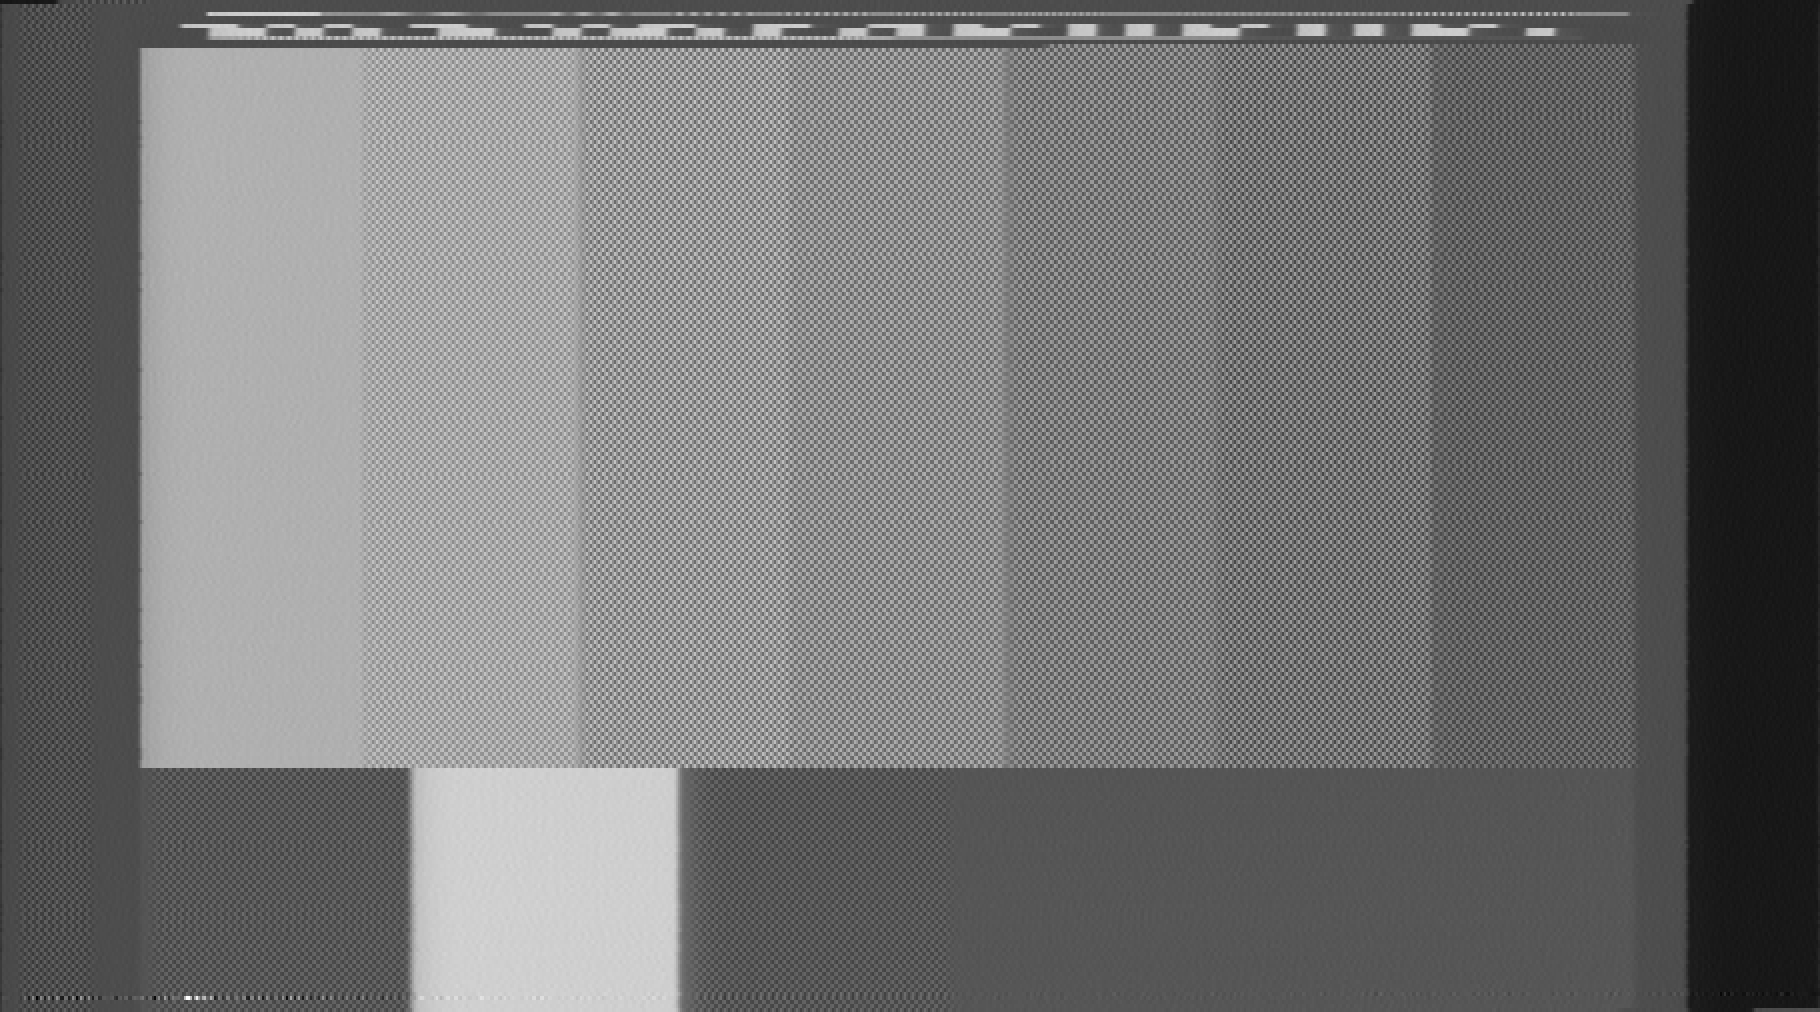

In [169]:
print(np.mean(finalsnr))
lines, sfactor = downscale(output, lineinfo3)

reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [170]:
lineinfo3

[(1153165, 1155043),
 (1155045.1003165401, 1156864.4318928756),
 (1156864.4065342685, 1158685.1869836131),
 (1158685.8767081511, 1160506.2982147641),
 (1160506.3070537609, 1162326.6455798117),
 (1162326.671701161, 1164146.2113689831),
 (1164146.1882466027, 1165967.4730567266),
 (1165967.5042828643, 1167787.8940333868),
 (1167787.9000075657, 1169608.2939069264),
 (1169608.2953764619, 1171428.7788133163),
 (1171428.8107410334, 1173248.2846293068),
 (1173248.2385064852, 1175069.4805959095),
 (1175069.6150243476, 1176889.8890084911),
 (1176889.8880245027, 1178710.3220185868),
 (1178710.3314516903, 1180530.6907912048),
 (1180530.6975253464, 1182351.1280369351),
 (1182351.1809651828, 1184171.4662705574),
 (1184171.471533729, 1185991.8983398974),
 (1185991.9291059007, 1187812.2180585645),
 (1187812.2738351498, 1189632.6935383347),
 (1189632.7392507542, 1191452.7965770999),
 (1191453.1481934406, 1193273.5515724553),
 (1193273.5594163265, 1195093.8885963634),
 (1195093.9201923108, 1196913.83137

In [171]:
lineinfo[3], lineinfo[4]

(1158684, 1160504)

/home/cpage/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/cpage/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/cpage/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(14.373313635841217, nan)

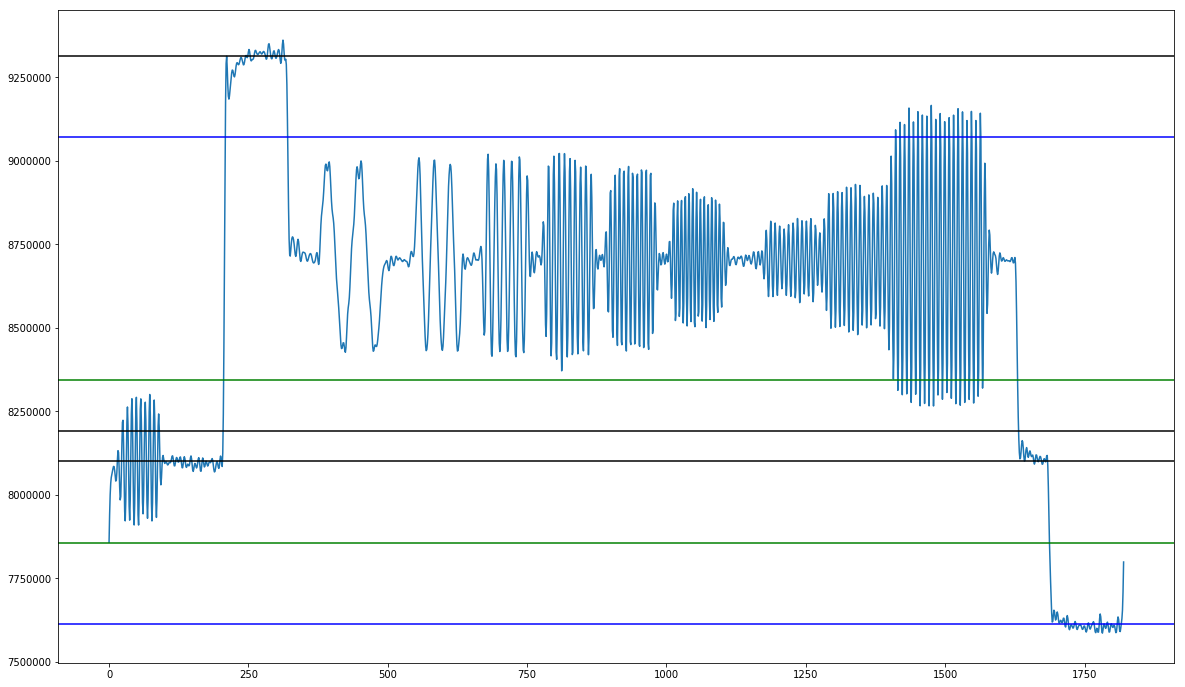

In [172]:
l = 3
x = output[int(lineinfo3[l][0]):int(lineinfo3[l+1][0])]
lineplot(x, filterset)
calcsnr(x[300:400]), calcsnr(x[2400:2530])

(17.351692098026351, 35.329880793360346)

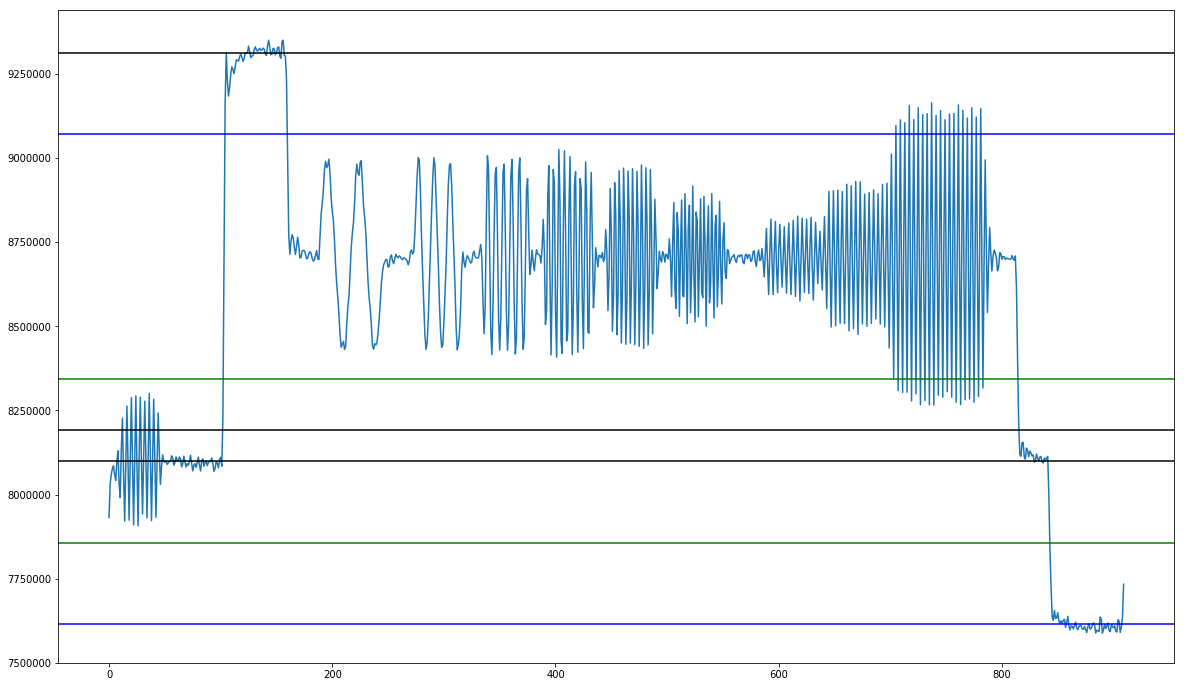

In [173]:
l = 3
x = lines[l * 910:(l + 1) * 910]
lineplot(x, filterset)
calcsnr(x[300:400]), calcsnr(x[850:])

In [695]:
snr = []
zcstart = []
zcend = []
zclen = []
for l in range(2, 250):
    preline = lines[(l * 910) - 20: (l * 910) + 20]
    _line = lines[(l * 910):(l + 2) * 910]
    
    x = lines[(910*l)+0:(910*l)+80]
    y = (x + lines[(910*l)+910:(910*l)+990]) / 2
    #plt.plot(y)

    zcstart.append(calczc(preline, 0, m20ire, 40) - 20)
    zcend.append(calczc(_line, 830, m20ire, 40))
    nextstart = calczc(_line, 900, m20ire, 40)
    zclen.append(nextstart - zcend[-1])
    snr.append(calcsnr(y[15:50]))
    print(l, calczc(preline, 0, m20ire, 40) - 20, calczc(_line, 830, m20ire, 40), calczc(_line, 900, m20ire, 40), calcsnr(y[15:50]))

2 -0.154741137918 845.368979898 909.861959977 37.4950262196
3 -0.138040022963 845.484546213 909.9074071 39.53515591
4 -0.0925929003539 845.450885029 909.909596074 38.2483850861
5 -0.0904039259235 845.431623837 909.909069945 38.7810154812
6 -0.090930054506 845.442284106 909.86090586 38.7791257511
7 -0.139094139965 845.425737295 909.832417702 39.7752201802
8 -0.167582298308 845.27221555 909.925389741 38.3505643762
9 -0.0746102585259 845.027630874 909.812592829 34.1564994399
10 -0.187407171451 845.224789305 909.883270826 38.0456201704
11 -0.116729174283 845.393663928 909.831584864 37.2948848883
12 -0.168415135823 845.195340354 909.928115571 36.7303025515
13 -0.0718844287775 845.338972519 909.837234703 36.2558223715
14 -0.162765296637 845.386983961 909.95733255 36.5790130216
15 -0.0426674502844 845.357508123 909.888763879 40.4586957605
16 -0.111236121343 845.278593138 909.928385346 37.6993434262
17 -0.0716146538122 845.114413832 909.880244413 38.2993437394
18 -0.119755586585 845.315334887 

In [696]:
np.mean(zclen), np.std(zclen)

(64.535136767752377, 0.11737262082938797)

In [697]:
np.std(zcstart), np.std(zcend), np.mean(snr)

(0.062264975967787954, 0.10891155743135103, 38.206862345726094)

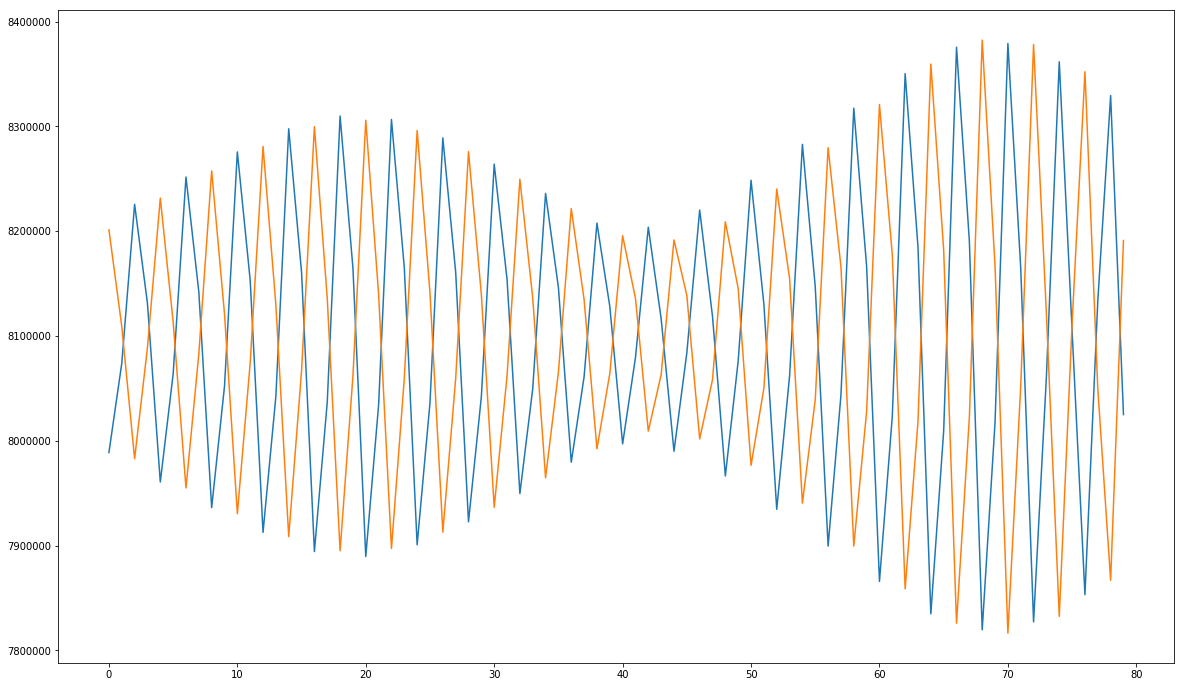

In [913]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)
l = l + 1
x = lines[(910*l)+0:(910*l)+80]
plt.plot(x)


In [770]:
lineinfo_cur[100], lineinfo_cur[101]

(1160549.1033076106, 1163347.4488508701)

43.451705388955098

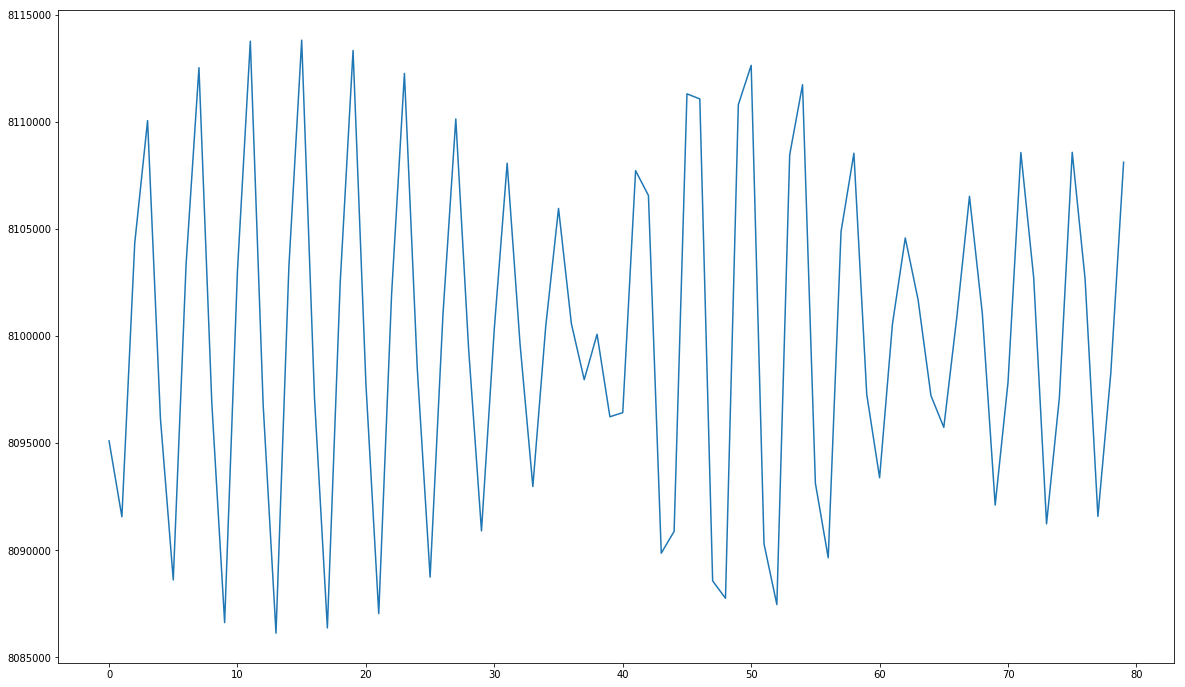

In [914]:
l = 17
x = lines[(910*l)+0:(910*l)+80]
#plt.plot(x)
l = l + 1
y = (x + lines[(910*l)+0:(910*l)+80]) / 2
plt.plot(y)
calcsnr(y[15:50])


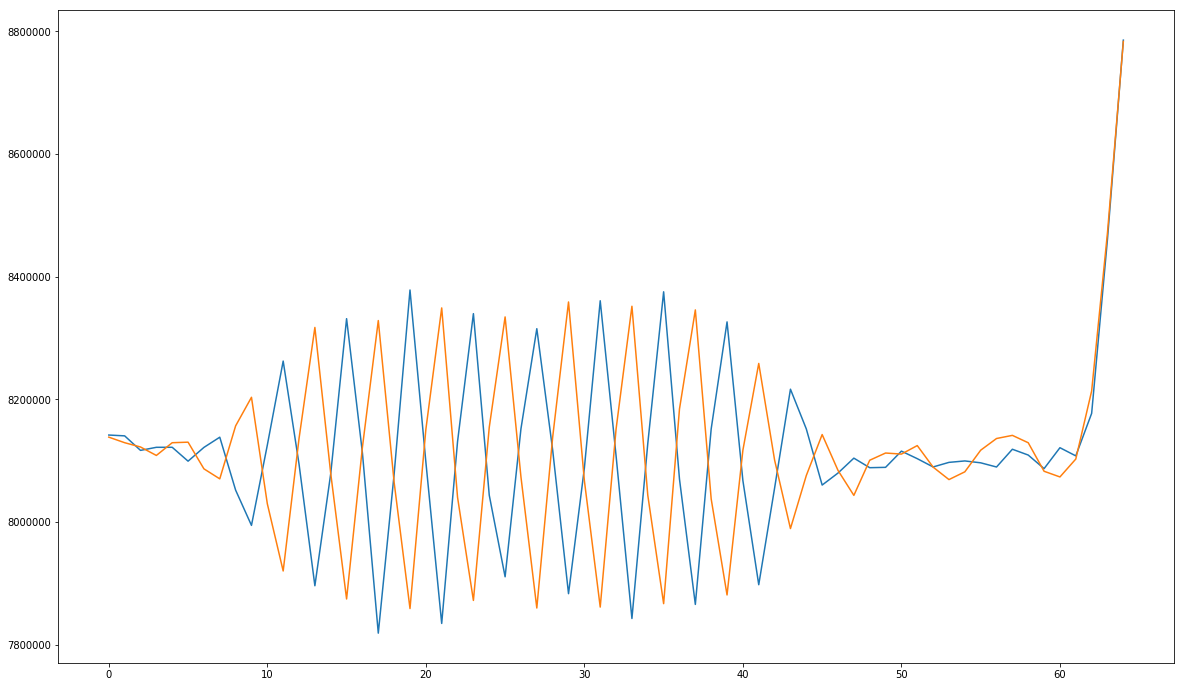

In [137]:
l = 50
x = lines[(910*l)+5:(910*l)+70]
plt.plot(x)
y = lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(y)

22.0131165809


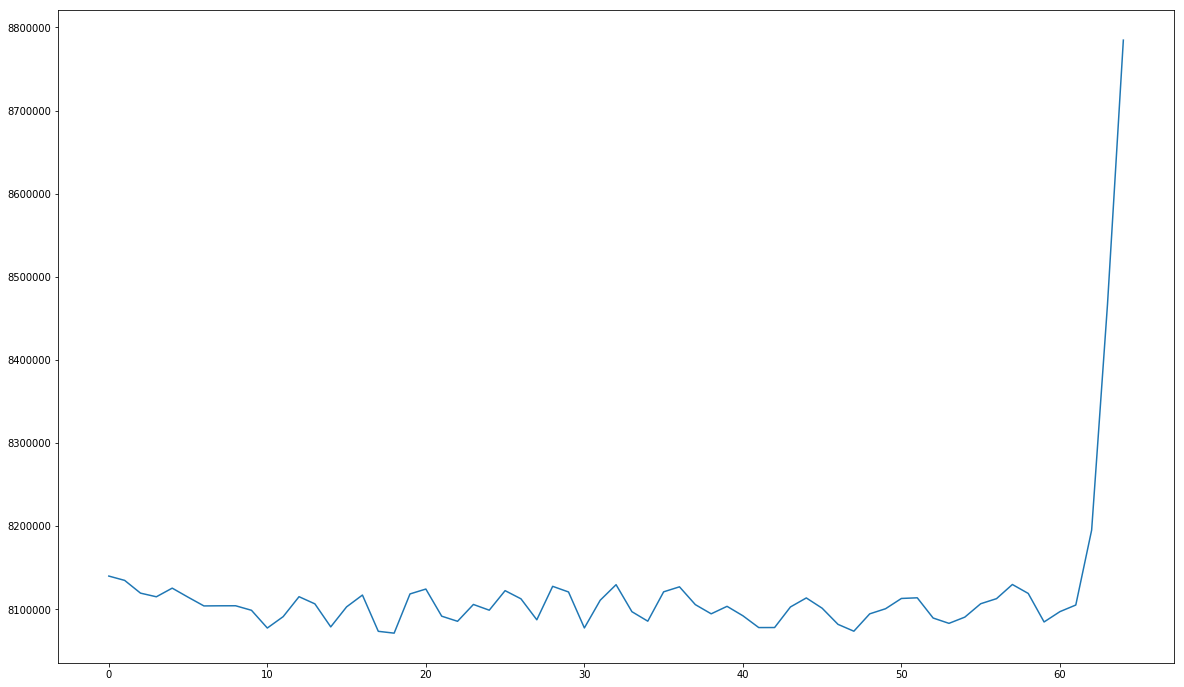

In [138]:
l = 50
x = lines[(910*l)+5:(910*l)+70] + lines[(910*(l+1))+5:(910*(l+1))+70]
plt.plot(x / 2)
calcsnr(x / 2)

(230230,)
uint8 (253, 910) (253, 910)


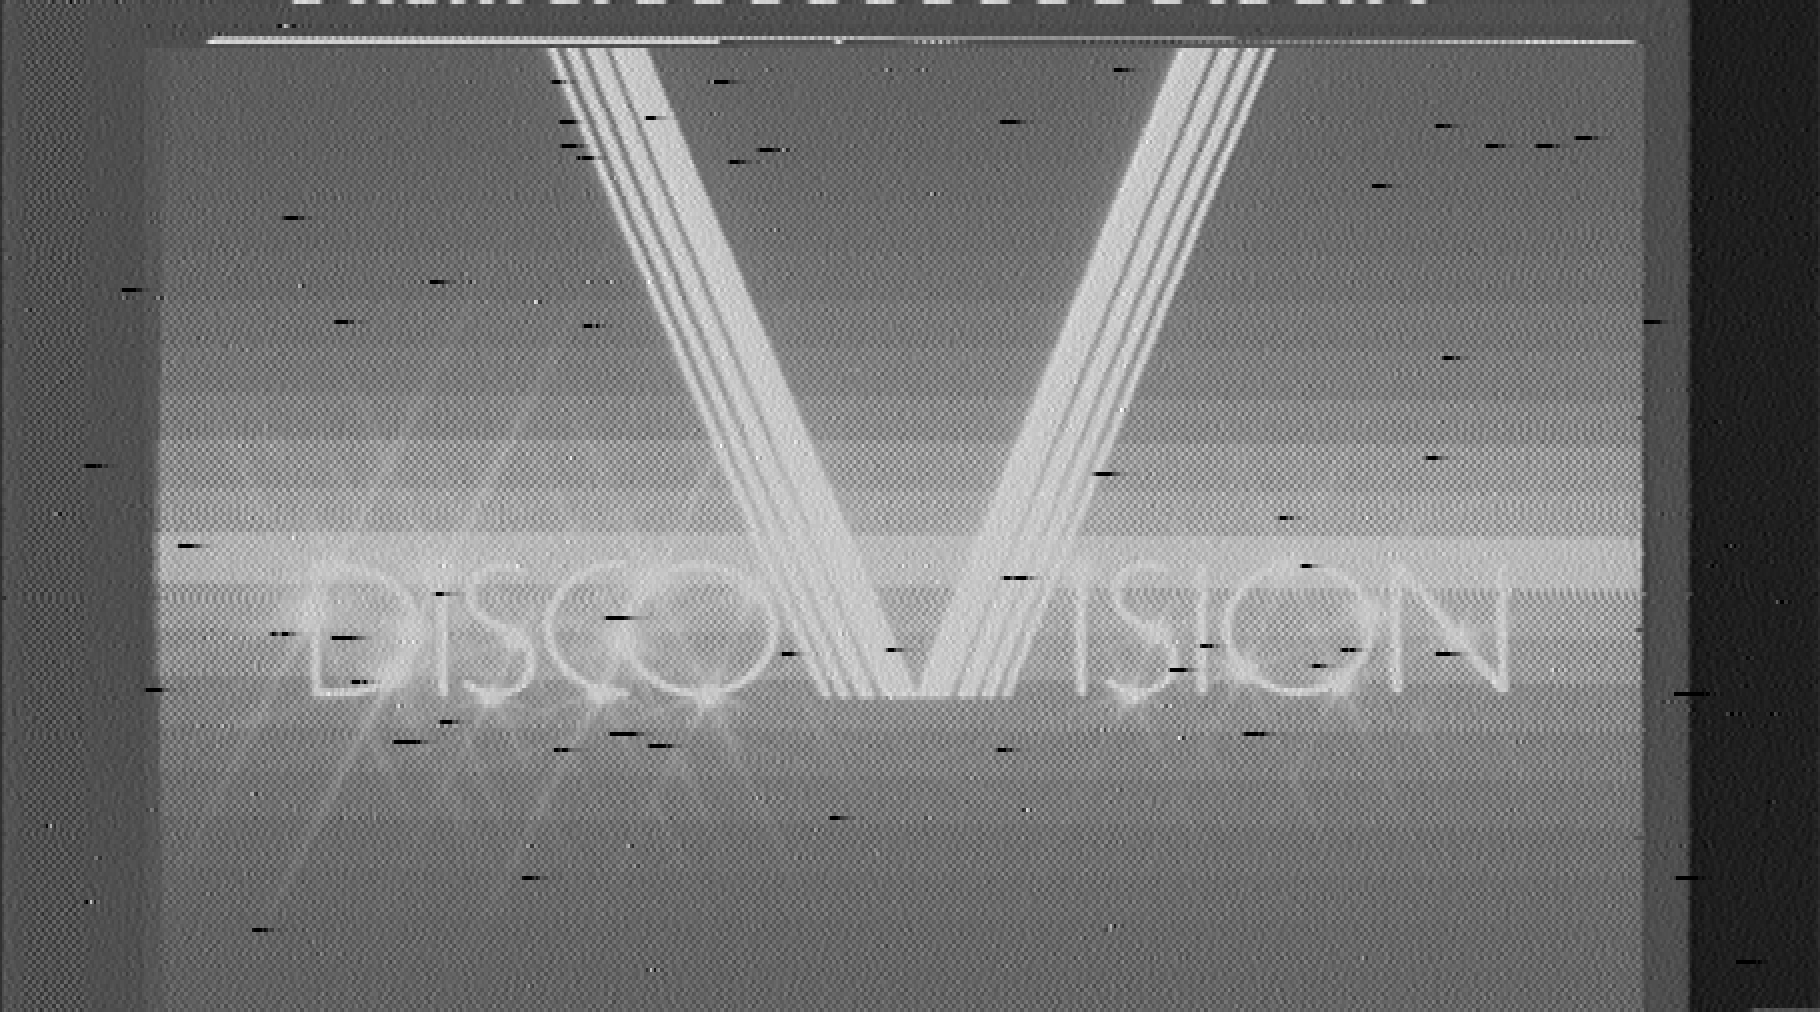

In [35]:
# Example of this code on a rotter :)
reduced = (lines - minn) / hz_ire_scale
lines16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)

drawdata(lines16, 910, len(lineinfo2)-1, hscale=2, vscale=4)

In [36]:
# figure out where vsync is supposed to begin, assuming line start at ire -20:

In [37]:
910/63.5, 58.5*(910/63.5)

(14.330708661417322, 838.3464566929133)

In [38]:
begline = []
endline = []
for l in range(0, len(lineinfo_cur) - 1):
    cline = lines[l * 910:(l + 1) * 910]
    begline.append(calczc(cline, 0, 8000000, 5))
    endline.append(calczc(cline, 840, m20ire, 20))
    if (begline[-1] is None):
        print("b", l)
        begline[-1] = -1
    if (endline[-1] is None):
        print("e", l)
        endline[-1] = 844.25

e 173
e 219


In [39]:
np.min(begline), np.max(begline), np.mean(begline), np.argmax(begline), np.std(begline)

(0.36511998949632013,
 2.7357543924367347,
 0.76349998963594301,
 149,
 0.25001621551811237)

In [40]:
np.min(endline), np.max(endline), np.mean(endline), np.argmax(endline), np.std(endline)

(840.20959013105346,
 845.70162781330214,
 844.23547566598813,
 148,
 0.44573642405298891)

In [41]:
linegaps2 = np.diff(lineinfo2)
linegaps_end = np.diff(lineinfo_cur)

In [42]:
np.mean(linegaps2), np.std(linegaps2), np.min(linegaps2), np.max(linegaps2)

(2794.1198310133477,
 2.2242912880402335,
 2786.4846006617881,
 2799.5613464718917)

In [43]:
np.mean(linegaps_end), np.std(linegaps_end), np.min(linegaps_end), np.max(linegaps_end)

(2794.1198310133477,
 2.2716834575987628,
 2786.4032574766316,
 2800.2662368090241)

In [44]:
filterset['line_px']

2794.0

In [45]:
lineinfo2[147] - lineinfo2[146], lineinfo_cur[147] - lineinfo_cur[146]

(2792.3583034544718, 2792.7066011009738)

In [46]:
lineinfo2[120] - lineinfo2[119], lineinfo_cur[120] - lineinfo_cur[119]

(2791.6145233304705, 2792.2245435791556)

In [47]:
endline[147]

844.04832559894965

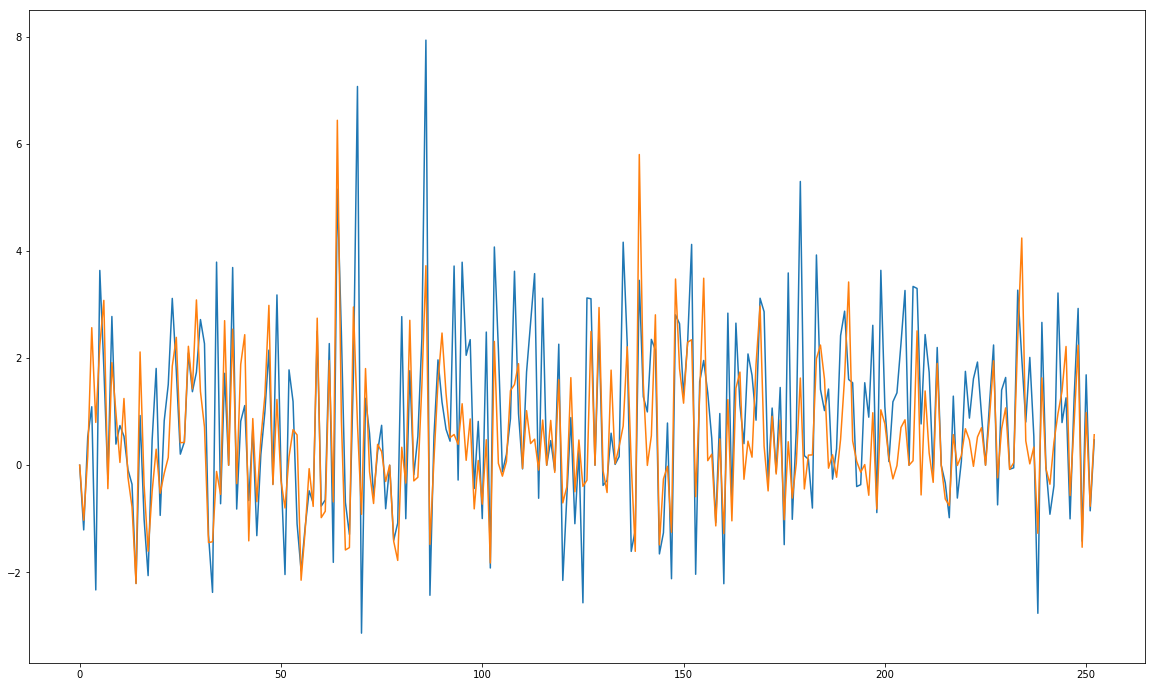

In [48]:
plt.plot(errs[0])
plt.plot(errs[-1])

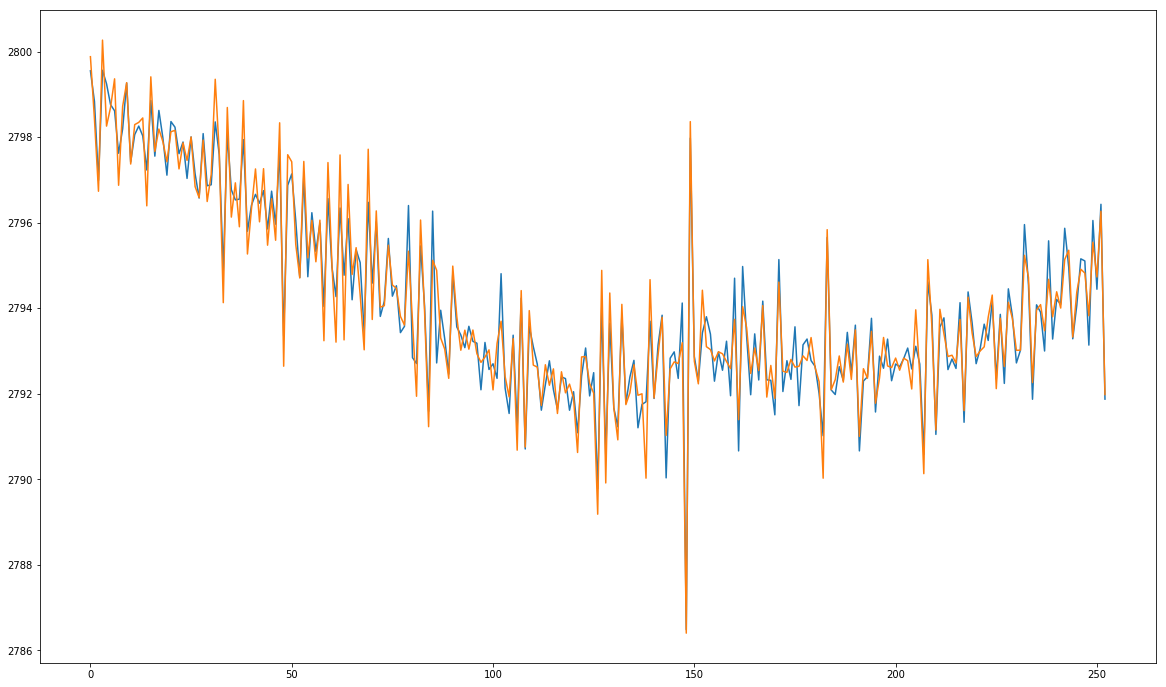

In [49]:
plt.plot(np.diff(lineinfo2))
plt.plot(np.diff(lineinfo_cur))

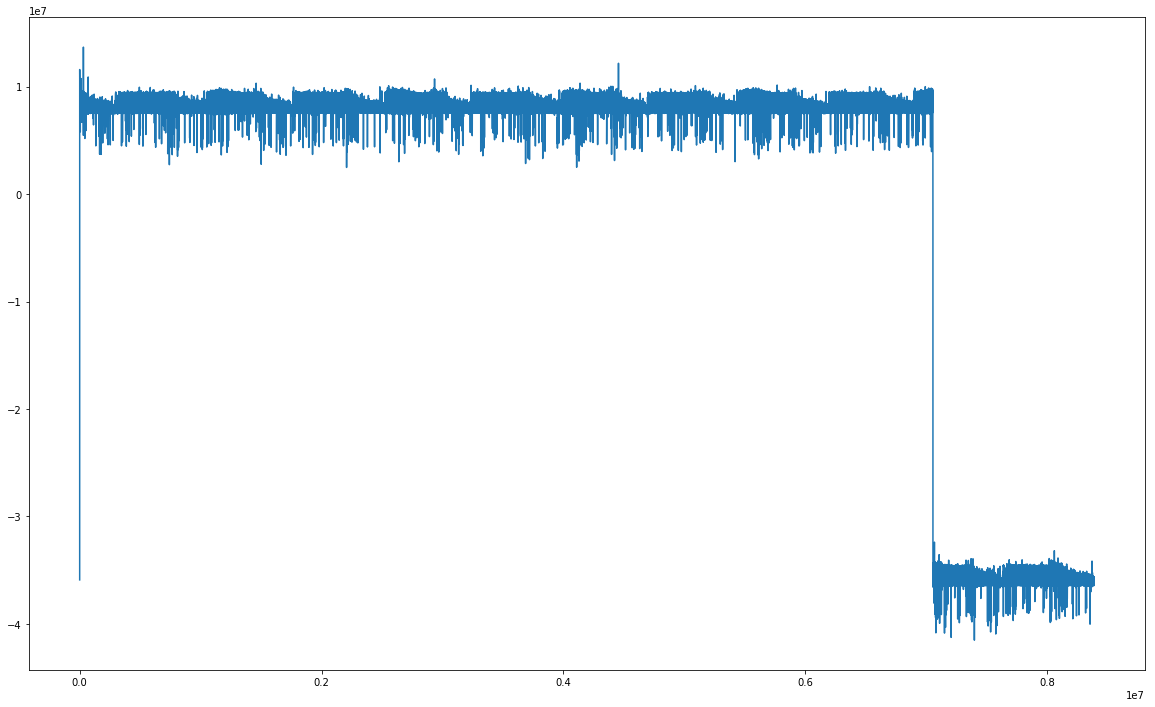

In [155]:
plt.plot(output)

In [22]:
len(output)

4194304

In [133]:
len(ocut)

4000000

In [136]:
cutlen = int(4000000 * (8 * 315/88 / 40))

In [137]:
o286_fft = np.fft.fft(ocut)

In [147]:

range(int(cutlen / 2), int(len(o286_fft) - (cutlen / 2)))

range(1431818, 2568182)

In [148]:
o286_fft_cut = np.delete(o286_fft, range(int(cutlen / 2), int(len(o286_fft) - (cutlen / 2))))

In [ ]:
output286 = np.fft.ifft(o286_fft_cut)

In [152]:
outfile = open('disco28.raw', 'wb')
outfile.write(output286)

45818176

In [82]:
output286 = scale(output, 94304, 8094304, 8000000 * (8 * 315/88) / 40)

/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


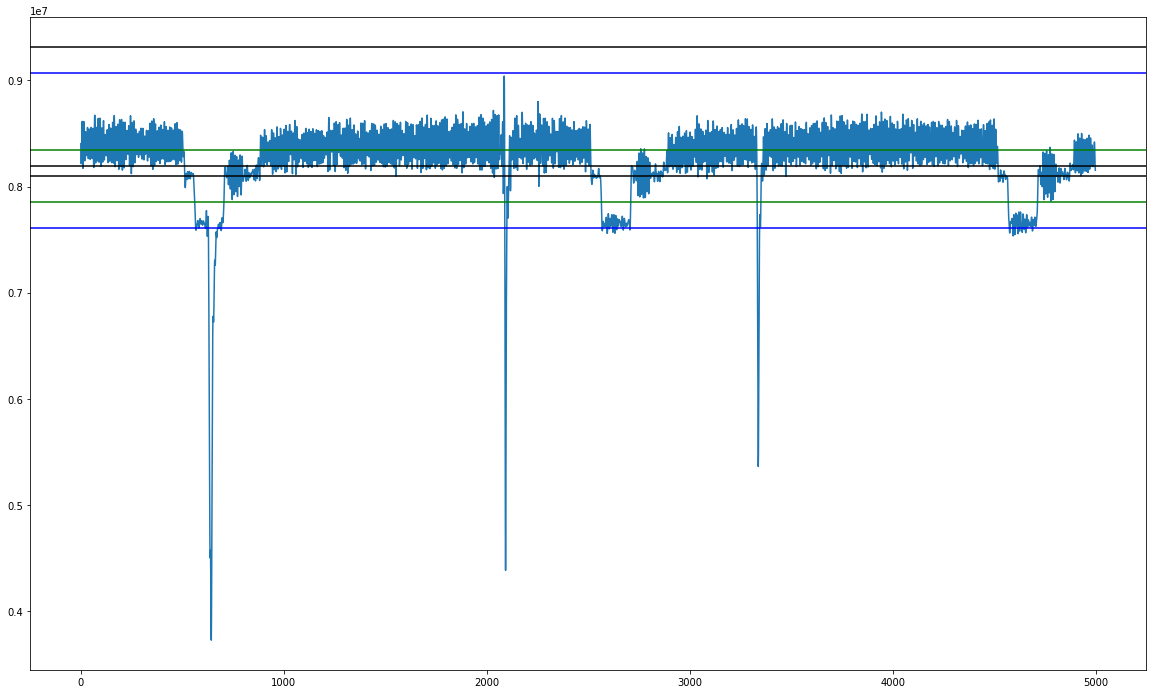

In [83]:
lineplot(output286[50000:55000], filterset)

In [119]:
# old lddecode format for hz->uint16 conversion
minire = -60
maxire = 140
hz_ire_scale = (9300000 - 8100000) / 100
minn = 8100000 + (hz_ire_scale * -60)
out_scale = 65534.0 / (maxire - minire)

In [120]:
reduced = (output286 - minn) / hz_ire_scale
output16 = np.uint16(np.clip(reduced * out_scale, 0, 65535) + 0.5)


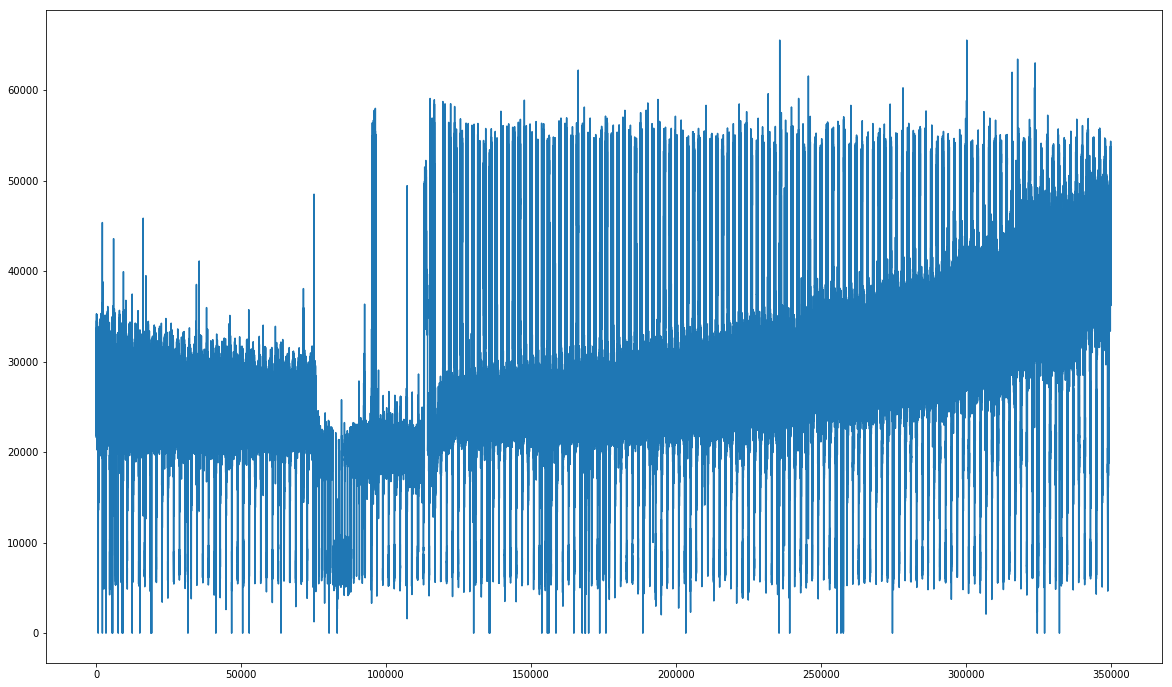

In [131]:
plt.plot(output16[50000:400000])

In [121]:
outfile = open('disco.ld', 'wb')
outfile.write(output16)

11454544

In [123]:
np.min(output16)

0

In [88]:
len(indata1)

16777216

In [92]:
cutlen = 64 * 1024

In [93]:
indata28 = scale(indata1, cutlen, len(indata1) - cutlen, (len(indata1) - (cutlen * 2)) * (8 * 315/88) / 40)


/home/cpage/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


In [116]:
indata28a = np.int16(np.clip(indata28, -32760, 32760))

In [117]:
np.min(indata28a)

-32760

In [118]:
outfile = open('disco28.raw', 'wb')
outfile.write(indata28a)

23834250

In [115]:
len(indata1)

16777216

In [96]:
(len(indata1) - (cutlen * 2)) * (8 * 315/88) / 40

11917125.818181818